# DSA5205 Project 2   |   YANG HANGXIAO   |   A0296909H

# **OutLine:**<a id='toc0_'></a>   

- [Dataset - CIFAR-10](#toc1_)

- [Supervised Learning Task - Image classification](#toc2_)
    
    Methods:

    - [Random Forest](#toc2_1)

    - [PCA + SVM](#toc2_2)

    - [ResNet-18](#toc2_3)

    - [CNN](#toc2_4)
    
    - [Vision Transformer](#toc2_5)

- [Unsupervised Learning Task - Image generation](#toc3_)

    Methods:

    - [VAE (Variational Autoencoder)](#toc3_1)

    - [GAN](#toc3_2)

    - [Stable Diffusion](#toc3_3)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# Prepare something

### Install and import necessary site-packages

In [19]:
# ! pip install --upgrade pip
# ! pip install torch
# ! pip install pandas
# ! pip install torchvision
# ! pip install --upgrade torch
# ! pip install thundersvm
# ! pip install datasets
# ! pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 3.1 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [1]:
import os
import time
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.models import resnet18
from torchvision.transforms import ToTensor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score, hinge_loss
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
# import cuml
# from cuml.svm import SVC # using GPU to accelerate the SVM training process.
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from joblib import dump, load
import ssl
from tqdm import tqdm
import math
from typing import Optional, Tuple, Union, List

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Seting environment

In [23]:
ssl._create_default_https_context = ssl._create_unverified_context


seed = 3407
# cite: Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# <a id='toc1_'></a>[Introduction of the Dataset - CIFAR-10](#toc0_)

The [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset is a widely used image dataset in the fields of machine learning and computer vision. It was collected and organized by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton at the University of Toronto. The dataset was created to provide a standard benchmark platform for image classification tasks, assisting researchers in evaluating and comparing the performance of different algorithms. Due to its moderate size and diverse categories, CIFAR-10 is extensively used to assess the performance of image classification algorithms, particularly in the training and testing of deep learning models.

### data enhancement

In [3]:
# Define data enhancement and preprocessing for training-sets
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Random Crop
    transforms.RandomHorizontalFlip(), # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color vibrance
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalization
])

# Define preprocessing for test-sets
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

### Loading Data

In [101]:
# Loading Train-set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False, num_workers=2)

# Loading Test-set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)



100%|██████████| 170498071/170498071 [00:03<00:00, 47572191.66it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



### Information of the CIFAR-10

In [5]:
train_size = len(trainset)
print(f'Size of train-set: {train_size}')

test_size = len(testset)
print(f'Size of test-set: {test_size}')

classes = trainset.classes
print(f'label of classes: {classes}')

image, _ = trainset[0]
print(f'Image size: {image.size()}')

Size of train-set: 50000
Size of test-set: 10000
label of classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image size: torch.Size([3, 32, 32])


Size of train-set: 50000
Size of test-set: 10000
label of classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Image size: torch.Size([3, 32, 32])

### Display some images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

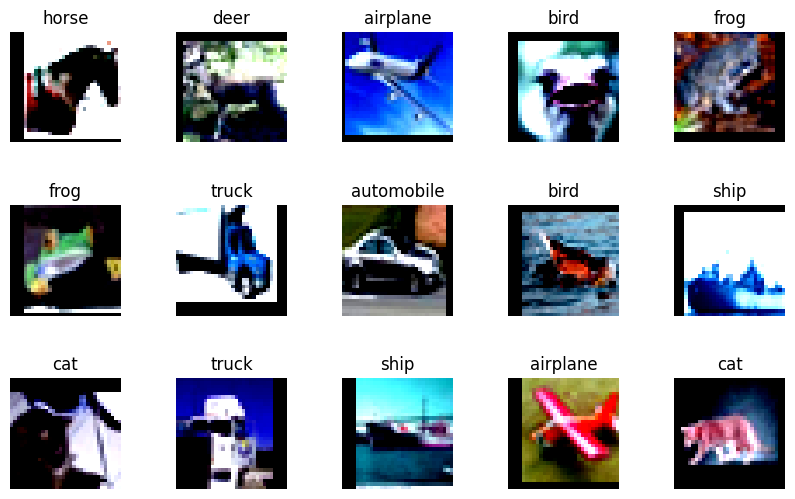

In [6]:
# Define a function to show some images in a grid view.    
def imshow(images, labels, nrows=3, ncols=5):
    # Show the images and print corresponding label
    # Config image grid view
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Show Images
    for i in range(3):
        for j in range(5):
            # Obtain the axes for each sub-images
            ax = axes[i, j] # Denormalization
            img = images[i * 5 + j] / 2 + 0.5
            npimg = img.numpy()
            # show image in the ax.
            ax.imshow(np.transpose(npimg, (1, 2, 0)))
            ax.set_title(classes[labels[i * 5 + j]])
            ax.axis('off') # hidden axis

    plt.show()
    
# Choose some train-set image randomly.
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=15, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(images, labels)

<img src="./images/class.png" alt="示例图片" width="500">

### Counting category

Class frog: 5000 
Class truck: 5000 
Class deer: 5000 
Class automobile: 5000 
Class bird: 5000 
Class horse: 5000 
Class ship: 5000 
Class cat: 5000 
Class dog: 5000 
Class airplane: 5000 


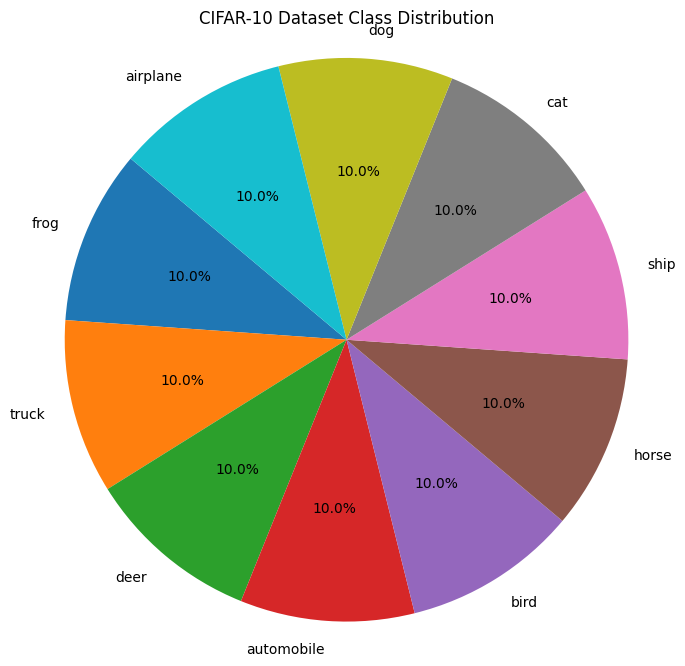

In [7]:
# Obtain all train-set labels
train_labels = [label for _, label in trainset]

# Count the number of samples for each category
label_counts = Counter(train_labels)
for label, count in label_counts.items():
    print(f'Class {classes[label]}: {count} ')
    

classes = trainset.classes

labels = [classes[label] for label in label_counts.keys()]
sizes = list(label_counts.values())

# Draw pie figure
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("CIFAR-10 Dataset Class Distribution")
plt.show()

Class frog: 5000 

Class truck: 5000 

Class deer: 5000 

Class automobile: 5000 

Class bird: 5000 

Class horse: 5000 

Class ship: 5000 

Class cat: 5000 

Class dog: 5000 

Class airplane: 5000

<img src="./images/classes.png" alt="示例图片" width="300">

### Computing Average Image

In [ ]:
# Calculate the average image for each category
category_images = {i: [] for i in range(10)}
for image, label in trainset:
    category_images[label].append(image.numpy())

# Stack the images and calculate the average
avg_images = {}
for label, images in category_images.items():
    avg_images[label] = np.mean(images, axis=0)

# visualization
# plt.figure(figsize=(10, 5))
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(np.transpose(avg_images[i], (1, 2, 0)))
#     plt.title(classes[i])
#     plt.axis('off')
# plt.show()

<img src="./images/avgimage.png" alt="示例图片" width="500">

### Similarity of categories

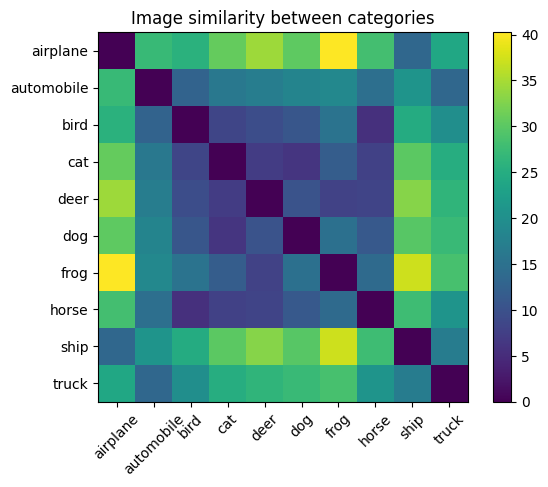

In [9]:
# Calculate the similarity of the average image for each category
avg_images_flat = [avg_images[i].reshape(-1) for i in range(10)]
similarity_matrix = pairwise_distances(avg_images_flat, metric='euclidean')

# Displays the similarity matrix
plt.imshow(similarity_matrix, cmap='viridis')
plt.colorbar()
plt.xticks(range(10), classes, rotation=45)
plt.yticks(range(10), classes)
plt.title('Image similarity between categories')
plt.show()

# <a id='toc2_'></a>[Task 1: Image Classification](#toc0_)

Image classification is a fundamental task in computer vision where the objective is to assign a label to an input image from a predefined set of classes. This task plays a central role in applications ranging from object recognition to medical imaging.

#### Task Objective

Given an image $ x $, the objective of image classification is to predict the correct class label $ y $ from a set of possible classes $ \{1, 2, \ldots, C\} $. Formally, we want to find a function $ f: X \rightarrow Y $, where $ X $ represents the input space (images) and $ Y $ is the label space.

The model, typically a neural network, outputs a probability distribution over the classes. Let $ \hat{y} = f(x; \theta) $ be the predicted class distribution, where $ \theta $ represents the model parameters. The probability for a given class $ i $ is represented as $ \hat{y}_i $, with:

$$
\sum_{i=1}^C \hat{y}_i = 1
$$

#### Evaluation Metrics

The performance of an image classification model is generally evaluated using accuracy, precision, recall, and F1-score. For multiclass classification tasks, accuracy is the most commonly used metric.

##### Accuracy

Accuracy is the ratio of correctly classified images to the total number of images:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} = \frac{\sum_{i=1}^N \mathbf{1}(\hat{y}_i = y_i)}{N}
$$

where $ N $ is the total number of images, $ \hat{y}_i $ is the predicted label, $ y_i $ is the true label, and $ \mathbf{1} $ is the indicator function, which is 1 if $ \hat{y}_i = y_i $ and 0 otherwise.

##### Cross-Entropy Loss

The cross-entropy loss is commonly used as the objective function during training for image classification. For a single image, the cross-entropy loss is:

$$
\mathcal{L} = - \sum_{i=1}^C y_i \log(\hat{y}_i)
$$

where \( y_i \) is the true label in one-hot encoding, and $ \hat{y}_i $ is the predicted probability of class $ i $. For a batch of $ N $ images, the average cross-entropy loss is:

$$
\mathcal{L}_{\text{batch}} = - \frac{1}{N} \sum_{j=1}^N \sum_{i=1}^C y_{j,i} \log(\hat{y}_{j,i})
$$

## <a id='toc2_1'></a>[Method 1.1: Random Forest](#toc0_)

Random Forest is an ensemble learning method primarily used for classification and regression tasks. It enhances model accuracy and robustness by constructing multiple decision trees and combining their predictions. The core idea of Random Forest is to utilize the "Bagging" (Bootstrap Aggregating) technique, generating multiple decision trees through various combinations of samples and features, thereby reducing the bias and variance of individual models.

<img src="./images/RandomForest.png" alt="示例图片" width="500">

#### Key Formulas

1. **Gini Impurity**: During the construction of decision trees, Gini Impurity is commonly used to measure the impurity of samples. It is defined as:

   $$
   \text{Gini}(D) = 1 - \sum_{k=1}^K p_k^2
   $$

   where $ p_k $ represents the proportion of samples belonging to the $ k $-th class, and $ K $ is the total number of classes. A lower Gini Impurity indicates higher data purity.

2. **Information Gain**: Another metric for assessing sample purity is Information Gain, which is used to select the optimal feature for splitting. It is defined as:

   $$
   IG(D, A) = \text{Entropy}(D) - \sum_{v \in \text{values}(A)} \frac{|D_v|}{|D|} \cdot \text{Entropy}(D_v)
   $$

   Here, $ \text{Entropy}(D) $ is the entropy of dataset $ D $, $ A $ is a feature, and $ D_v $ is the subset of $ D $ where feature $ A $ takes value $ v $. Higher Information Gain indicates that feature $ A $ is more suitable for splitting the data.

3. **Prediction in Random Forest (Voting and Averaging)**: In classification tasks, Random Forest employs majority voting for predictions:

   $$
   \hat{y} = \text{mode}\{ h_t(x) \mid t = 1, \dots, T \}
   $$

   In regression tasks, it uses the average of all trees' predictions:

   $$
   \hat{y} = \frac{1}{T} \sum_{t=1}^{T} h_t(x)
   $$

   where $ T $ denotes the number of decision trees, and $ h_t(x) $ is the prediction from the $ t $-th tree.

### Drocessing Data

In [10]:
# Extract train-set data and labels
X_train = np.array([np.ravel(image.numpy()) for image, _ in trainset])
y_train = np.array([label for _, label in trainset])

# Extract test-set data and labels
X_test = np.array([np.ravel(image.numpy()) for image, _ in testset])
y_test = np.array([label for _, label in testset])

### Setting Hyperparameters

In [11]:
# Using k cross validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

n_estimators = 100  # the number of trees in the random forest.
model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
print(model)

### Train model

**Due to the significant time and computational resources required for training, I have commented out the training process here.**

In [12]:
# os.makedirs('./model_RandomForest_checkpoints', exist_ok=True) # path to save model.

# fold_accuracies = []
# fold_times = []

# for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
#     print(f'Fold {fold + 1}/{k_folds}')
    
#     # Divide the training set and the verification set
#     X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#     y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
#     # initialize model
#     model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    
#     # record start time
#     start_time = time.time()
    
#     # train model
#     model.fit(X_train_fold, y_train_fold)
    
#     # record end time
#     end_time = time.time()
#     epoch_time = end_time - start_time
#     fold_times.append(epoch_time)
    
#     # predict in val-set
#     y_val_pred = model.predict(X_val_fold)
    
#     # computw accuracy
#     val_accuracy = accuracy_score(y_val_fold, y_val_pred)
#     fold_accuracies.append(val_accuracy)
    
#     print(f'Fold {fold + 1}, Accuracy: {val_accuracy:.4f}, Time: {epoch_time:.2f} secs')
    
#     # save current fold model
#     model_path = f'./model_RandomForest_checkpoints/best_RandomForest_model_fold_{fold + 1}.joblib'
#     dump(model, model_path)
#     print(f'Model saved to {model_path}')


Fold 1/5
Fold 1, Accuracy: 0.4545, Time: 67.34 secs
Model saved to ./model_RandomForest_checkpoints/best_RandomForest_model_fold_1.joblib
Fold 2/5
Fold 2, Accuracy: 0.4577, Time: 67.38 secs
Model saved to ./model_RandomForest_checkpoints/best_RandomForest_model_fold_2.joblib
Fold 3/5
Fold 3, Accuracy: 0.4597, Time: 67.56 secs
Model saved to ./model_RandomForest_checkpoints/best_RandomForest_model_fold_3.joblib
Fold 4/5
Fold 4, Accuracy: 0.4655, Time: 66.81 secs
Model saved to ./model_RandomForest_checkpoints/best_RandomForest_model_fold_4.joblib
Fold 5/5
Fold 5, Accuracy: 0.4480, Time: 66.76 secs
Model saved to ./model_RandomForest_checkpoints/best_RandomForest_model_fold_5.joblib



### Find the best model
**Due to the significant time and computational resources required for this step, I have commented out the training process here.**

In [13]:
# model_dir = './model_RandomForest_checkpoints'
# k_folds = 5
# test_accuracies = []

# for fold in range(1, k_folds + 1):
#     model_path = os.path.join(model_dir, f'best_RandomForest_model_fold_{fold}.joblib')
#     if os.path.exists(model_path):
#         # loading model
#         model = load(model_path)
#         print(f'Loaded model from {model_path}')
        
#         # predict in test-set
#         y_test_pred = model.predict(X_test)
        
#         # compute accuracy in test-set
#         test_accuracy = accuracy_score(y_test, y_test_pred)
#         test_accuracies.append(test_accuracy)
        
#         print(f'Fold {fold} Test Accuracy: {test_accuracy:.4f}')
#     else:
#         print(f'Model for fold {fold} not found at {model_path}')

# if test_accuracies:
#     avg_test_accuracy = np.mean(test_accuracies)
#     print(f'\nAverage Test Accuracy across folds: {avg_test_accuracy:.4f}')
# else:
#     print('No models were evaluated.')


Loaded model from ./model_RandomForest_checkpoints/best_RandomForest_model_fold_1.joblib
Fold 1 Test Accuracy: 0.4596
Loaded model from ./model_RandomForest_checkpoints/best_RandomForest_model_fold_2.joblib
Fold 2 Test Accuracy: 0.4641
Loaded model from ./model_RandomForest_checkpoints/best_RandomForest_model_fold_3.joblib
Fold 3 Test Accuracy: 0.4626
Loaded model from ./model_RandomForest_checkpoints/best_RandomForest_model_fold_4.joblib
Fold 4 Test Accuracy: 0.4653
Loaded model from ./model_RandomForest_checkpoints/best_RandomForest_model_fold_5.joblib
Fold 5 Test Accuracy: 0.4650

Average Test Accuracy across folds: 0.4633



In [16]:
# load the 4-th fold model
model_path = './models/best_RandomForest_model_fold_4.joblib'
model = load(model_path)
print(f'Loaded model from {model_path}')

# prdict in test-set
y_test_pred = model.predict(X_test)

# caompute accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy for fold 4: {0.4653}')

Loaded model from ./models/best_RandomForest_model_fold_4.joblib
Test Accuracy for fold 4: 0.4653


## <a id='toc2_2'></a>[Method 1.2 PCA + SVM](#toc0_)

In machine learning, **Principal Component Analysis (PCA)** and **Support Vector Machines (SVM)** are commonly combined to handle high-dimensional data by reducing dimensionality and performing classification.

#### 1. Principal Component Analysis (PCA)

<img src="./images/PCA.png" alt="示例图片" width="500">

PCA is a dimensionality reduction technique that projects high-dimensional data onto a lower-dimensional space while preserving as much variance as possible. The main steps of PCA are:

1. **Data Centering**: Subtract the mean from each feature to center the data.
   $$
   X_{\text{centered}} = X - \mu
   $$
   where \( \mu \) is the mean vector of the features.

2. **Covariance Matrix Calculation**: Compute the covariance matrix of the centered data.
   $$
   \Sigma = \frac{1}{n} X_{\text{centered}}^\top X_{\text{centered}}
   $$

3. **Eigen Decomposition**: Calculate the eigenvalues and eigenvectors of the covariance matrix. Select the top $ k $ eigenvectors to form the projection matrix \( W \).

4. **Dimensionality Reduction**: Project the original data onto the new $ k $-dimensional subspace.
   $$
   X_{\text{PCA}} = X_{\text{centered}} W
   $$

#### 2. Support Vector Machines (SVM)

<img src="./images/SVM.png" alt="示例图片" width="500">

SVM is a supervised learning algorithm used for classification tasks. It aims to find the optimal hyperplane that separates classes with the maximum margin. For a binary classification problem with training samples $ (x_i, y_i) $, where $ y_i \in \{-1, 1\} $, the objective is to minimize:
$$
\min \frac{1}{2} ||w||^2
$$
subject to the constraint:
$$
y_i (w \cdot x_i + b) \geq 1, \quad \forall i
$$
where $ w $ is the normal vector to the hyperplane, and $ b $ is the bias term. This optimization can be solved using Lagrange multipliers, leading to the dual formulation.

#### 3. Combining PCA and SVM

In high-dimensional datasets, SVM performance may degrade due to the curse of dimensionality. To address this, PCA can be applied before SVM to reduce the data's dimensionality. The combined approach involves:

1. **Dimensionality Reduction**: Apply PCA to reduce the data to $ k $ dimensions.

2. **Classification**: Use the reduced data as input to the SVM for classification.

This combination helps maintain high classification performance while reducing computational complexity.

源







### Data processing and hyperparameter

In [54]:
# The image data is flattened into a one-dimensional vector and normalized
X_train = np.array([np.ravel(image.numpy()) for image, _ in trainset]) / 255.0
y_train = np.array([label for _, label in trainset])
# Extract test set data and labels
X_test = np.array([np.ravel(image.numpy()) for image, _ in testset]) / 255.0
y_test = np.array([label for _, label in testset])

# K fold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

pca = PCA(n_components=100)
print(pca)

PCA(n_components=100)


In [55]:
model = SVC(kernel='rbf', C=1.0, probability=True)
print(model)

SVC(probability=True)


### Train model
**Due to the significant time and computational resources required for training, I have commented out the training process here.**

In [18]:
# # record training results for each folds
# fold_accuracies = []
# fold_times = []

# # train and evaluate in each fold
# for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
#     print(f'\nFold {fold + 1}/{k_folds}')

#     # devide data
#     X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#     y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
#     # X_train_fold_pca = pca.fit_transform(X_train_fold)
#     # X_val_fold_pca = pca.transform(X_val_fold)
#     # X_test_pca = pca.transform(X_test)
#     # X_test_pcas.append(X_test_pca)

#     # initialize SVM model on cuML (Using GPU acceleration)
#     svm = SVC(kernel='rbf', C=1.0, probability=True)  # choose RBF kernel

#     model = Pipeline([
#     ('pca', pca),
#     ('svm', svm)
#     ])

#     # record start time
#     start_time = time.time()

#     # train model
#     model.fit(X_train_fold, y_train_fold)

#     # compute training time use
#     end_time = time.time()
#     fold_time = end_time - start_time
#     fold_times.append(fold_time)

#     # predict in val-set
#     y_val_pred = model.predict(X_val_fold)

#     # compute accuracy
#     val_accuracy = accuracy_score(y_val_fold, y_val_pred)
#     fold_accuracies.append(val_accuracy)
    
#     print(f'Fold {fold + 1} - Accuracy: {val_accuracy:.4f}, Time: {fold_time:.2f} seconds')

#     # save model
#     model_path = f'./model_SVM_checkpoints/best_SVM_model_fold_{fold + 1}.joblib'
#     dump(model, model_path)
#     print(f'Model saved to {model_path}')

# # compute avg-acc and avg-time use
# avg_accuracy = np.mean(fold_accuracies)
# avg_time = np.mean(fold_times)

# print(f'\nAverage Accuracy across folds: {avg_accuracy:.4f}')
# print(f'Average Time per Fold: {avg_time:.2f} seconds')


Fold 1/5
Fold 1 - Accuracy: 0.5193, Time: 23.52 seconds
Model saved to ./model_SVM_checkpoints/best_SVM_model_fold_1.joblib

Fold 2/5
Fold 2 - Accuracy: 0.5211, Time: 23.92 seconds
Model saved to ./model_SVM_checkpoints/best_SVM_model_fold_2.joblib

Fold 3/5
Fold 3 - Accuracy: 0.5169, Time: 23.87 seconds
Model saved to ./model_SVM_checkpoints/best_SVM_model_fold_3.joblib

Fold 4/5
Fold 4 - Accuracy: 0.5218, Time: 24.89 seconds
Model saved to ./model_SVM_checkpoints/best_SVM_model_fold_4.joblib

Fold 5/5
Fold 5 - Accuracy: 0.5198, Time: 25.78 seconds
Model saved to ./model_SVM_checkpoints/best_SVM_model_fold_5.joblib

Average Accuracy across folds: 0.5198
Average Time per Fold: 24.40 seconds



### Find the best model
**Due to the significant time and computational resources required for this step, I have commented out the training process here.**

In [19]:
# # model path
# model_dir = './model_SVM_checkpoints'
# test_accuracies = []

# # traverse saved model
# for fold in range(1, 6): 
#     model_path = os.path.join(model_dir, f'best_SVM_model_fold_{fold}.joblib')
#     if os.path.exists(model_path):
#         # load model
#         model = load(model_path)
#         print(f'Loaded model from {model_path}')
        
#         # predict in test-set
#         y_test_pred = model.predict(X_test)
        
#         # compute accuracy
#         test_accuracy = accuracy_score(y_test, y_test_pred)
#         test_accuracies.append(test_accuracy)
        
#         print(f'Test Accuracy for fold {fold}: {test_accuracy:.4f}')
#     else:
#         print(f'Model for fold {fold} not found at {model_path}')

# if test_accuracies:
#     avg_test_accuracy = np.mean(test_accuracies)
#     print(f'\nAverage Test Accuracy across folds: {avg_test_accuracy:.4f}')
# else:
#     print('No models were evaluated.')


Loaded model from ./model_SVM_checkpoints/best_SVM_model_fold_1.joblib
Test Accuracy for fold 1: 0.5215
Loaded model from ./model_SVM_checkpoints/best_SVM_model_fold_2.joblib
Test Accuracy for fold 2: 0.5207
Loaded model from ./model_SVM_checkpoints/best_SVM_model_fold_3.joblib
Test Accuracy for fold 3: 0.5236
Loaded model from ./model_SVM_checkpoints/best_SVM_model_fold_4.joblib
Test Accuracy for fold 4: 0.5206
Loaded model from ./model_SVM_checkpoints/best_SVM_model_fold_5.joblib
Test Accuracy for fold 5: 0.5216

Average Test Accuracy across folds: 0.5216



This code is running on the kaggle platform, because I do not have a GPU on my PC, so I can not use cuML library, this paragraph I directly give the results, and comment out the test code

In [21]:
# # 加载第 3 折的模型
# model_path = './models/best_SVM_model_fold_3.joblib'
# model = load(model_path)
# print(f'Loaded model from {model_path}')

# # 在测试集上进行预测
# y_test_pred = model.predict(X_test)

# # 计算测试集准确率
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f'Test Accuracy for fold 3: {test_accuracy:.4f}')


Loaded model from ./model_SVM_checkpoints/best_SVM_model_fold_3.joblib
Test Accuracy for fold 3: 0.5236



## <a id='toc2_3'></a>[Method 1.3: ResNet-18](#toc0_)

ResNet, short for Residual Network, is a deep convolutional neural network architecture introduced by Kaiming He et al. in 2015. It addresses the degradation problem in deep networks by incorporating residual blocks, allowing the construction of significantly deeper networks without performance degradation. ResNet-18 is a variant of this architecture, consisting of 18 layers.

#### 1. Residual Block

<img src="./images/cancha.png" alt="示例图片" width="300">

The core component of ResNet is the residual block, which introduces shortcut connections to mitigate the vanishing gradient problem. For an input $ x $, the output of a residual block is:

$$
y = F(x, \{W_i\}) + x
$$

Here, $ F(x, \{W_i\}) $ represents the residual mapping to be learned, and \( x \) is the input that is directly added to the output of $ F $. This direct addition is known as a shortcut or skip connection.

#### 2. Network Architecture

<img src="./images/ResNet.png" alt="示例图片" width="900">

ResNet-18 comprises the following layers:

1. **Initial Convolution and Pooling:**
   - 7×7 convolution with 64 filters and a stride of 2
   - Batch normalization
   - ReLU activation
   - 3×3 max pooling with a stride of 2

2. **Residual Blocks:**
   - Four stages, each with a set of residual blocks:
     - **Stage 1:** 2 blocks with 64 filters
     - **Stage 2:** 2 blocks with 128 filters
     - **Stage 3:** 2 blocks with 256 filters
     - **Stage 4:** 2 blocks with 512 filters

   Each block consists of two 3×3 convolutional layers followed by batch normalization and ReLU activation. The shortcut connections in these blocks enable the network to learn identity mappings, facilitating the training of deeper networks.

3. **Final Layers:**
   - Global average pooling
   - Fully connected layer with 1000 neurons (for classification into 1000 classes)

#### 3. Loss Function

During training, ResNet-18 typically uses the cross-entropy loss function for classification tasks. For a single training example, the loss $ L $ is defined as:

$$
L = -\sum_{i=1}^N y_i \log(\hat{y}_i)
$$

Where:
- $ N $ is the number of classes
- $ y_i $ is the ground truth label (one-hot encoded)
- $ \hat{y}_i $ is the predicted probability for class $ i $

#### 4. Backpropagation and Optimization

Training involves updating the network's weights to minimize the loss function. Using gradient descent, the weight $ w $ is updated as follows:

$$
w = w - \eta \frac{\partial L}{\partial w}
$$

Where:
- $ \eta $ is the learning rate
- $ \frac{\partial L}{\partial w} $ is the gradient of the loss with respect to the weight

Optimizers like Stochastic Gradient Descent (SGD) or Adam are commonly used to perform these updates efficiently.


ResNet-18's introduction of residual blocks with shortcut connections has significantly advanced deep learning by enabling the training of much deeper networks without the degradation problem. Its architecture has been foundational in various computer vision tasks, demonstrating robust performance across multiple applications.

### Define model and hyperparameters

In [53]:
# Load the pre-trained ResNet-18 model
net = resnet18(pretrained=False)
print(net)

# Modify the first convolution layer and the fully connected layer to fit the CIFAR-10 dataset
net.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
net.maxpool = nn.Identity()  # Remove the maximum pooling layer
net.fc = nn.Linear(512, 10)  # CIFAR-10 has 10 categories

# Move model to GPU (if available)
net = net.to(device)

# Define Loss function, optimizer and scheduler.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Define hyperparameter
num_epochs = 100
batch_size = 128
learning_rate = 0.001
k_folds = 5

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train model
**Due to the significant time and computational resources required for training, I have commented out the training process here.**

In [27]:
# # Train model
# # Define checkpoints path
# os.makedirs('model_ResNet18_checkpoints', exist_ok=True)

# # initialize KFold
# kfold = KFold(n_splits=k_folds, shuffle=True)

# # record the best acc of each folds
# fold_best_accuracies = []

# loss_k = []
# acc_k = []
# for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):
#     print(f'Fold {fold + 1}/{k_folds}')
    
#     # Define dataloader
#     train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
#     val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
#     train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_subsampler)
#     val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_subsampler)
    
#     # Load the pre-trained ResNet-18 model
#     model = resnet18(pretrained=False)
    
#     # Modify the first convolution layer and the fully connected layer to fit the CIFAR-10 dataset
#     model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#     model.maxpool = nn.Identity()  # Remove the maximum pooling layer
#     model.fc = nn.Linear(512, 10)  # CIFAR-10 has 10 categories
#     model = model.to(device)
    
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
#     # initialize best accuracy
#     best_accuracy = 0.0
    
#     # train model
#     loss_i = []
#     acc_i = []
#     for epoch in range(num_epochs):
#         start_time = time.time()
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()
        
#         # evaluate model
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
        
#         accuracy = 100 * correct / total
        
#         end_time = time.time()  # record end time
#         epoch_duration = end_time - start_time
        
#         print(f'Fold {fold + 1}, Epoch [{epoch + 1}/{num_epochs}], Loss {running_loss / len(train_loader):.4f}, Acc {accuracy:.2f}%, Time {epoch_duration:.2f} secs')
#         loss_i.append(running_loss / len(train_loader))
#         acc_i.append(accuracy)
        
#         # save the better one
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             torch.save(model.state_dict(), f'model_ResNet18_checkpoints/best_ResNet18_model_fold_{fold + 1}.pth')
    
#     print(f'Best Validation Accuracy for fold {fold + 1}: {best_accuracy:.2f}%')
#     fold_best_accuracies.append(best_accuracy)
#     loss_k.append(loss_i)
#     acc_k.append(acc_i)

# print(f'Average Best Validation Accuracy across folds: {np.mean(fold_best_accuracies):.2f}%')


Fold 1/5
Fold 1, Epoch [1/100], Loss 1.2598, Acc 57.77%, Time 28.36 secs
Fold 1, Epoch [2/100], Loss 0.7816, Acc 72.33%, Time 26.98 secs
Fold 1, Epoch [3/100], Loss 0.5779, Acc 72.32%, Time 27.00 secs
Fold 1, Epoch [4/100], Loss 0.4410, Acc 72.89%, Time 27.19 secs
Fold 1, Epoch [5/100], Loss 0.3237, Acc 79.80%, Time 27.08 secs
Fold 1, Epoch [6/100], Loss 0.2330, Acc 77.65%, Time 27.38 secs
Fold 1, Epoch [7/100], Loss 0.1633, Acc 81.55%, Time 27.05 secs
Fold 1, Epoch [8/100], Loss 0.1128, Acc 79.52%, Time 27.21 secs
Fold 1, Epoch [9/100], Loss 0.0947, Acc 78.18%, Time 27.33 secs
Fold 1, Epoch [10/100], Loss 0.0723, Acc 79.74%, Time 27.03 secs
Fold 1, Epoch [11/100], Loss 0.0577, Acc 81.31%, Time 27.00 secs
Fold 1, Epoch [12/100], Loss 0.0624, Acc 79.86%, Time 27.13 secs
Fold 1, Epoch [13/100], Loss 0.0488, Acc 81.09%, Time 26.99 secs
Fold 1, Epoch [14/100], Loss 0.0486, Acc 79.67%, Time 27.16 secs
Fold 1, Epoch [15/100], Loss 0.0476, Acc 81.38%, Time 27.17 secs
Fold 1, Epoch [16/100], 

### Visual training process

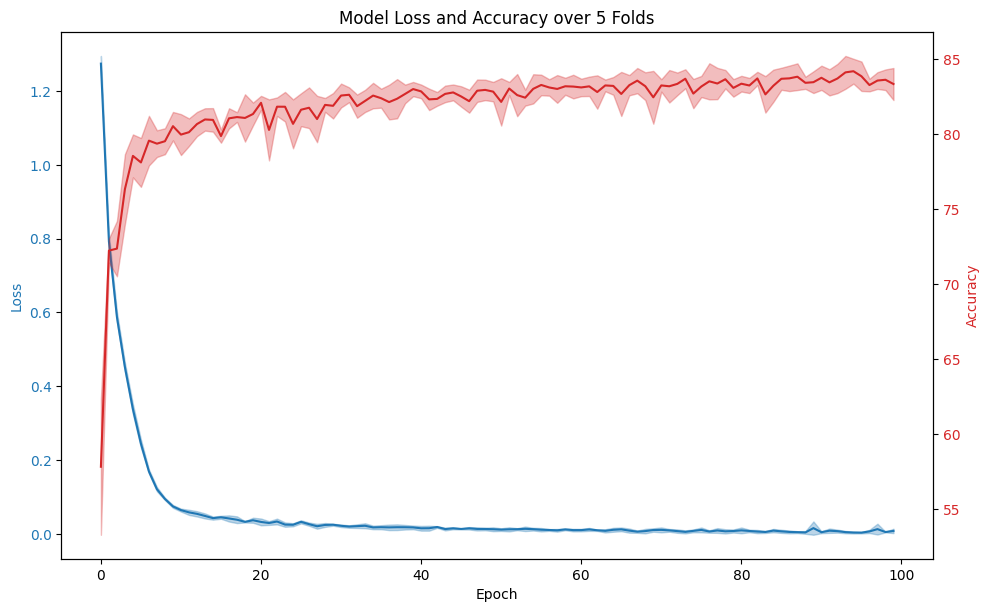

In [42]:
def draw_loss(loss_data, acc_data, trials=5):
    N = len (loss_data[0])

    loss_mean = np.mean(loss_data, axis=0)
    loss_std = np.std(loss_data, axis=0)
    acc_mean = np.mean(acc_data, axis=0)
    acc_std = np.std(acc_data, axis=0)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color_loss = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color_loss)
    ax1.plot(range(N), loss_mean, color=color_loss, label='Mean Loss')
    ax1.fill_between(range(N), loss_mean - loss_std, loss_mean + loss_std, color=color_loss, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor=color_loss)

    ax2 = ax1.twinx()
    color_acc = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color_acc)
    ax2.plot(range(N), acc_mean, color=color_acc, label='Mean Accuracy')
    ax2.fill_between(range(N), acc_mean - acc_std, acc_mean + acc_std, color=color_acc, alpha=0.3)
    ax2.tick_params(axis='y', labelcolor=color_acc)

    fig.tight_layout()
    plt.title('Model Loss and Accuracy over {} Folds'.format(trials))
    plt.show()
    

# loss_data = loss_k
# acc_data = acc_k

# use pre-porcessed data
loss_data = [[1.2597866252588388, 0.7815760701609115, 0.5778538115298786, 0.4410485162045628, 0.3236572523943532, 0.23297433298045453, 0.1632676459015749, 0.11280829256501632, 0.09471242171459304, 0.07225238405667936, 0.05773624057729785, 0.06242856446701212, 0.04877732145025755, 0.048571431820396894, 0.04759925144751327, 0.04660042376218798, 0.044065415127256424, 0.03560534147203516, 0.03271292140722251, 0.032955826858219246, 0.02787869261985365, 0.026310301456115424, 0.04316078854007676, 0.028658495090839366, 0.02118110412786813, 0.027952021647679112, 0.02559201483381912, 0.02759841300945836, 0.023614189288870525, 0.02104521522163815, 0.020886744385192425, 0.017602506683475096, 0.020428877867354353, 0.031003545404199105, 0.01820451276369033, 0.008416311086901945, 0.013520106472070895, 0.026323515783471706, 0.019256077688217115, 0.014758073437533836, 0.010872599735888415, 0.02152853240906157, 0.0202042835099941, 0.014245660205032939, 0.012804943889665146, 0.015115635631021675, 0.013107039229864382, 0.008184726865416892, 0.01415865735554236, 0.021565136850018207, 0.009194243593799202, 0.00394831302674283, 0.009926823679627512, 0.021902700266488398, 0.018421832022324842, 0.00690610359439646, 0.011974438478438052, 0.009639063751831399, 0.0140664055223332, 0.00797069612113605, 0.008911664772731514, 0.012562265690070571, 0.0118025432635047, 0.016172395923514122, 0.010570745262151477, 0.0049994156503356795, 0.0031815667678982574, 0.007169599967201879, 0.018286300942715713, 0.010784800573784566, 0.0036988139115612414, 0.006490769442962846, 0.01033295346270096, 0.013440763643139769, 0.007682756217309652, 0.0031885514984426842, 0.003120482262930657, 0.011658787261375038, 0.01782631667112536, 0.011153981098599755, 0.00407707402615479, 0.0025714777045349143, 0.0033769847343468624, 0.009015034983073279, 0.0141287903263899, 0.008305793728472252, 0.0037169212415979354, 0.0057350816344967845, 0.0040570606610339024, 0.010393309750751317, 0.0065803075652767955, 0.005092243822474438, 0.006389343936845512, 0.005975524357454444, 0.005008302860845399, 0.005009583153715617, 0.008954996585403066, 0.00660160237441796, 0.0037880816149371273, 0.008957989093309757], [1.2907640117045027, 0.8187371435256812, 0.6110622845709134, 0.46975409656096573, 0.359881740884659, 0.2635729487616414, 0.17583914576009058, 0.12896895099181338, 0.0992933845819947, 0.07851922657852546, 0.06760396952993764, 0.05282259082344298, 0.05833050378631003, 0.04167417881968684, 0.04409890454679061, 0.05127521004742041, 0.045761967152238084, 0.03319725853587373, 0.033303504067729, 0.04100948754257668, 0.03198498897641278, 0.030858146354776267, 0.03451330752294963, 0.019434904604525374, 0.022146188645637013, 0.03374377786986732, 0.033978759415653016, 0.02314829213463645, 0.019564140047346162, 0.0256762615095946, 0.01718467296245835, 0.020248985246787914, 0.030365168981268235, 0.015063745923397598, 0.011062698983228408, 0.02253828724236644, 0.02964222653692338, 0.01509857723538127, 0.009346829669781776, 0.01586894084840415, 0.027496375607329603, 0.009407310353661961, 0.02078792098758983, 0.00950548829904221, 0.01983293021166959, 0.011956493779083345, 0.015226735051973505, 0.013984246954339342, 0.009136082094466572, 0.00959128350323139, 0.017621098063456953, 0.016200483880909947, 0.016841293117064927, 0.011057022518345182, 0.007986302193584881, 0.007374134088774173, 0.01218321198312463, 0.015520143457193719, 0.011592501768316612, 0.008938696120269898, 0.01314641962115844, 0.0101793010416529, 0.01191444599750573, 0.008438660411866004, 0.009147922713028717, 0.00935822609475793, 0.00881642861157033, 0.010941402954903461, 0.010513381075155669, 0.00510760632627957, 0.0026232625867954754, 0.01601242658369929, 0.015619927399243918, 0.0041039866088123725, 0.0025472688835484827, 0.0035456873837699625, 0.007514765955092096, 0.020726227990904685, 0.007072683840149217, 0.0038494410938944555, 0.002239438592944305, 0.008563150483941006, 0.015036279344404959, 0.005859972250177067, 0.010149486254259666, 0.0059740043218825395, 0.00365268264010175, 0.006508298271907556, 0.011144917705469168, 0.007916900776251805, 0.003826373905209771, 0.008023291296567753, 0.01230301458153249, 0.009558241225103717, 0.0034691894319615686, 0.0018961789813193826, 0.003163393934808035, 0.001365238827859978, 0.006353251079429155, 0.0176991548805251], [1.3033334104397807, 0.8111392442410746, 0.5963080124542736, 0.46174905813349704, 0.34609226696788314, 0.2501736630837377, 0.17501876000969555, 0.1202613800026167, 0.09043138523618825, 0.07861413196110116, 0.06924923064526373, 0.048543964759610335, 0.05935131588254493, 0.050639954701321904, 0.04587275902190195, 0.04002122037237683, 0.036215653001797944, 0.0379169528371098, 0.03517890578067412, 0.04544653729148828, 0.019642760664166602, 0.038814677471167056, 0.03852786497918133, 0.01774826693830613, 0.02131269427987869, 0.03723238043847104, 0.025177825742904038, 0.015514523060188983, 0.032452127481542956, 0.024491117573707713, 0.02021050742550637, 0.0204313673945062, 0.020680522503027807, 0.02573324823636746, 0.013390658831641528, 0.016890683410742794, 0.022147825869066586, 0.027924808886492798, 0.01361347469525373, 0.010953937798512343, 0.009992641183562925, 0.02500845672576294, 0.01505023596151665, 0.011259195879932096, 0.012713940014316777, 0.014949866855666176, 0.02109070544470676, 0.014822810875272718, 0.010325993627871233, 0.008328715758519054, 0.012943131835408175, 0.01922741509377421, 0.011905356079964645, 0.00908383015608218, 0.015074342246974086, 0.016011976819658748, 0.006500365321664195, 0.006068114870770525, 0.009740766360208365, 0.016985259362040445, 0.008959230483340278, 0.006482935632291152, 0.010266461658382457, 0.007880047304104246, 0.015642589674477327, 0.013830910385575164, 0.008292333521867564, 0.0031878463087283166, 0.0028982653145013695, 0.01466745608797846, 0.01686091686491282, 0.0076880427936579995, 0.0035307111856252398, 0.0036877645829089902, 0.00947312621828693, 0.014929981304892561, 0.005916715267651275, 0.006848102103844032, 0.004983181796542165, 0.011893241241450712, 0.008399554909063361, 0.006363158771072371, 0.004288951041079956, 0.005550933992429501, 0.008427091523468863, 0.013600870451038947, 0.008900868110363596, 0.004370114392023619, 0.00217658179729779, 0.008488691790802704, 0.00786161340276969, 0.0102408472925244, 0.007364148059004889, 0.003071994351406707, 0.0023141444676417077, 0.005106796578787815, 0.013908724624750252, 0.01114491499875482, 0.0058332079163239785, 0.002732451661922649], [1.2456762274614157, 0.7697226704119112, 0.5749243045576845, 0.4460274093924239, 0.333201852421791, 0.23912479354741092, 0.1644098296309241, 0.11730311681834844, 0.09725147058455327, 0.06843303410877911, 0.06430935460223129, 0.06834079734624003, 0.043201612718492606, 0.06036692506190354, 0.04056273732548609, 0.041504783625045, 0.02952856127137003, 0.05578920451742701, 0.0299084288601469, 0.02598444355938869, 0.04752890578956126, 0.02621176440942699, 0.020074413196680643, 0.0334698105087361, 0.02787219583519553, 0.027742428732061456, 0.027022029596608512, 0.026896246169625333, 0.01829595748798553, 0.024197339170003166, 0.025811813538336156, 0.025776249688146964, 0.0174088731758481, 0.01348089123239217, 0.023961153722884425, 0.023960863543375316, 0.00842838036923888, 0.008209522309192916, 0.027145343012929247, 0.022554509365520538, 0.01257867396402079, 0.012913686073345754, 0.02026414485836473, 0.011097088115462384, 0.014499251427474437, 0.013495748173523569, 0.01142934059835141, 0.020248362426303873, 0.01910319901364387, 0.008331737322334836, 0.007027801551420287, 0.014670318191320213, 0.01513414469202787, 0.006967703483732099, 0.009857283732664144, 0.01780595921417743, 0.013026480249072702, 0.006001007507641011, 0.010037734463718681, 0.009858112384177619, 0.015024269864070244, 0.012865777693063277, 0.006717220256741537, 0.006670764458127283, 0.01779181303398497, 0.013827381696172758, 0.005093777391955144, 0.002276753762650163, 0.0036724929896662594, 0.016676559228631704, 0.01863851450672284, 0.0063983578108895095, 0.004298512113113968, 0.001866540232374671, 0.007323609771327947, 0.019800322726300095, 0.012383902743029165, 0.0037591926288405957, 0.0036533981475424396, 0.010531815097589589, 0.009152062322749416, 0.009546058264681133, 0.005055845500336931, 0.005102683271296485, 0.011481209184010008, 0.006610785842630562, 0.01038169320540714, 0.007328594968358853, 0.001499132565880771, 0.0006108225769351, 0.0004961140281162565, 0.01890981613590479, 0.010973308512334936, 0.005410882146045184, 0.007855436560930684, 0.005140777666337164, 0.005864066773162417, 0.00442780321719066, 0.004582418288041612, 0.010155861363706243], [1.2692901050320828, 0.7800222715249838, 0.577630930815261, 0.4387013420891076, 0.3262404319577324, 0.23664981698075804, 0.16656344319684818, 0.1256436579072247, 0.09220479257678547, 0.07455935497610523, 0.06365651103516166, 0.059931252635241794, 0.06219316689898602, 0.04214860038599743, 0.03577348689724224, 0.04596465957401612, 0.053901681474174935, 0.02959792090530772, 0.0325812593998072, 0.039744824328022406, 0.035395538932405796, 0.02535893868791838, 0.03185268202365135, 0.026888904023391846, 0.03151436069792065, 0.036997987243448036, 0.020433309174458177, 0.010772196069890157, 0.0275105391483986, 0.02916870144976544, 0.025903370843593256, 0.01595242256970002, 0.016437920462228535, 0.02523513781084395, 0.021414141635597943, 0.0191844388981686, 0.014793360692961438, 0.013235592927079657, 0.021055969347717602, 0.024057503029709302, 0.015177547752027051, 0.008364791475139155, 0.017445154902142154, 0.019854088449261537, 0.01599536365781057, 0.01182976439457607, 0.01526379568175749, 0.010177187385299196, 0.014289541124927287, 0.015700584415498132, 0.011486377427298664, 0.008332375587468532, 0.010177326903553136, 0.02003366902850705, 0.01315984630905361, 0.008725910381008216, 0.009705334511325553, 0.011566353682479739, 0.015795843395712852, 0.007834312979863903, 0.0057344501463713286, 0.01888267185696428, 0.008921724238543408, 0.0027466755082262936, 0.002720797953000651, 0.019972583015196246, 0.01940698720110854, 0.006921408152614628, 0.002932545049955075, 0.005722976756960605, 0.012862423442719375, 0.0115965634640031, 0.00431308084992629, 0.004723527821363369, 0.014294126054856736, 0.01275500495214768, 0.00363400712885545, 0.003566035537545985, 0.0015171720756791964, 0.0019701005417365708, 0.024199286358153518, 0.012955583365431938, 0.004186204313744081, 0.0007242724124848545, 0.0006645971853212571, 0.0004338843069409034, 0.00019632361661566254, 7.935590168761238e-05, 0.0013608666755555515, 0.05119438721934488, 0.004301780060776279, 0.0013081930166674992, 0.0006093856326640325, 0.00031871943183461507, 0.00013276839386547183, 8.870089941294468e-05, 0.0018410479562049433, 0.04150762006037157, 0.00498379847862272, 0.00116308232630569]]
acc_data = [[57.77, 72.33, 72.32, 72.89, 79.8, 77.65, 81.55, 79.52, 78.18, 79.74, 81.31, 79.86, 81.09, 79.67, 81.38, 79.22, 80.21, 81.14, 78.11, 80.62, 81.73, 81.04, 81.26, 82.1, 82.33, 82.1, 81.65, 79.91, 81.22, 81.71, 82.61, 82.27, 81.87, 81.41, 83.2, 81.96, 82.31, 80.65, 82.08, 82.87, 82.56, 81.33, 82.53, 82.51, 83.16, 81.95, 82.23, 82.13, 81.91, 81.93, 83.55, 83.32, 80.16, 81.68, 83.48, 81.95, 83.29, 82.45, 82.47, 83.72, 82.43, 83.3, 80.93, 82.73, 83.24, 83.81, 82.93, 82.02, 81.38, 83.19, 82.83, 82.77, 82.02, 82.53, 81.65, 83.42, 83.05, 81.44, 82.82, 83.95, 83.81, 82.89, 83.06, 81.32, 82.17, 83.14, 82.97, 82.78, 83.24, 82.24, 82.67, 83.39, 82.31, 82.89, 83.13, 82.7, 83.09, 83.18, 83.39, 82.07], [63.25, 72.33, 71.42, 76.2, 79.65, 78.52, 79.57, 77.8, 80.19, 81.21, 78.95, 81.61, 82.06, 81.72, 80.17, 79.89, 80.66, 80.75, 81.9, 82.39, 82.37, 79.68, 82.27, 82.96, 77.72, 82.0, 83.33, 83.72, 82.65, 83.37, 83.09, 82.82, 81.88, 83.57, 82.92, 82.29, 82.61, 83.36, 83.88, 83.08, 83.22, 83.03, 82.88, 83.29, 83.22, 82.7, 81.09, 83.64, 83.33, 82.34, 82.17, 83.2, 83.88, 83.29, 84.08, 83.85, 82.3, 81.81, 84.21, 83.78, 83.04, 83.42, 83.06, 83.58, 83.99, 83.33, 83.76, 83.83, 83.85, 84.34, 83.68, 81.32, 83.21, 84.13, 84.48, 83.85, 81.43, 83.24, 83.69, 83.62, 84.2, 82.79, 83.65, 82.02, 83.07, 84.01, 83.57, 83.1, 83.28, 83.52, 84.26, 83.27, 83.29, 84.53, 84.26, 84.15, 83.3, 84.48, 82.53, 82.57], [62.56, 70.85, 75.97, 79.33, 76.58, 79.8, 80.12, 80.32, 80.63, 81.6, 80.62, 80.53, 80.41, 81.7, 81.07, 80.42, 82.11, 81.26, 82.18, 81.4, 82.9, 76.75, 82.74, 81.32, 82.03, 82.3, 82.55, 81.78, 81.85, 80.86, 82.89, 82.22, 80.58, 81.77, 83.37, 81.77, 79.99, 83.49, 82.6, 83.91, 83.24, 81.78, 82.75, 83.22, 82.54, 81.55, 82.65, 83.75, 83.76, 82.9, 79.14, 82.55, 84.09, 82.53, 82.6, 83.61, 84.0, 84.56, 83.19, 82.39, 83.97, 84.22, 83.76, 83.44, 82.64, 83.47, 84.05, 84.53, 83.77, 82.07, 83.49, 84.3, 84.1, 83.64, 82.55, 83.03, 84.14, 84.18, 83.25, 82.56, 83.03, 84.19, 83.78, 83.11, 83.12, 82.89, 83.7, 84.0, 83.65, 83.27, 83.2, 83.27, 83.86, 84.65, 84.44, 83.55, 82.76, 83.05, 84.22, 84.23], [53.5, 72.39, 71.22, 78.41, 79.74, 75.24, 76.55, 80.1, 79.04, 81.08, 77.85, 79.95, 80.11, 80.96, 80.06, 80.3, 80.85, 81.7, 82.39, 81.99, 81.7, 82.81, 81.09, 80.22, 80.73, 82.37, 79.31, 80.17, 82.01, 82.18, 81.07, 82.38, 83.0, 82.06, 81.01, 82.48, 83.45, 80.92, 82.36, 82.69, 82.12, 82.35, 81.66, 81.77, 81.88, 83.31, 81.77, 81.96, 83.4, 83.55, 83.0, 82.57, 82.66, 82.6, 81.35, 83.59, 83.1, 82.98, 83.22, 82.09, 82.62, 82.81, 82.36, 82.88, 82.52, 83.09, 83.53, 83.96, 83.55, 79.27, 83.63, 83.59, 83.49, 83.96, 82.05, 81.91, 84.25, 83.84, 84.07, 82.91, 82.98, 83.06, 83.75, 82.09, 82.6, 83.55, 83.11, 84.04, 84.11, 84.13, 83.77, 82.38, 83.88, 82.9, 83.66, 83.39, 84.04, 83.24, 83.6, 82.99], [52.14, 73.37, 71.01, 74.96, 77.08, 79.46, 80.14, 79.19, 79.7, 79.13, 81.22, 78.8, 79.79, 80.95, 82.17, 79.62, 81.54, 80.94, 80.92, 80.42, 81.85, 81.23, 81.89, 82.64, 80.72, 79.47, 82.06, 79.56, 82.12, 81.43, 83.31, 83.54, 82.1, 82.37, 82.46, 83.58, 82.43, 83.49, 82.59, 82.58, 83.21, 83.2, 82.03, 82.73, 83.21, 83.15, 83.35, 83.1, 82.45, 83.55, 82.99, 83.67, 82.32, 82.16, 83.69, 83.5, 82.97, 83.37, 82.97, 83.98, 83.61, 82.29, 84.03, 83.71, 83.79, 79.8, 82.15, 83.6, 83.53, 83.51, 82.71, 84.08, 84.04, 84.31, 82.89, 83.77, 84.84, 84.28, 84.58, 82.48, 82.9, 83.39, 84.44, 84.82, 85.28, 84.97, 85.35, 85.33, 82.93, 84.26, 84.99, 85.06, 85.31, 85.72, 85.59, 85.61, 83.28, 84.01, 84.49, 84.95]]


draw_loss(loss_data, acc_data)

<img src="./images/loss_resnet.png" alt="示例图片" width="700">

### Fine the best model
**Due to the significant time and computational resources required for this step, I have commented out the training process here.**

In [28]:
# # record the acc of models on the test-set of each folds
# test_accuracies = []

# for fold in range(k_folds):
#     # load saved model
#     model = resnet18(pretrained=False)
#     model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#     model.maxpool = nn.Identity()  # Remove the maximum pooling layer
#     model.fc = nn.Linear(512, 10)  # CIFAR-10 has 10 classes
#     model.load_state_dict(torch.load(f'model_ResNet18_checkpoints/best_ResNet18_model_fold_{fold + 1}.pth'))
#     model = model.to(device)
#     model.eval()

#     # evaluate models in test-set
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in testloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     test_accuracy = 100 * correct / total
#     test_accuracies.append(test_accuracy)
#     print(f'Test Accuracy for fold {fold + 1}: {test_accuracy:.2f}%')

# average_test_accuracy = np.mean(test_accuracies)
# print(f'Average Test Accuracy across folds: {average_test_accuracy:.2f}%')


Test Accuracy for fold 1: 83.91%
Test Accuracy for fold 2: 83.46%
Test Accuracy for fold 3: 83.94%
Test Accuracy for fold 4: 83.50%
Test Accuracy for fold 5: 84.76%
Average Test Accuracy across folds: 83.91%



In [33]:
# load model
model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity() # Remove the maximum pooling layer
model.fc = nn.Linear(512, 10) # CIFAR-10 has 10 classes
model = model.to(device)

# load saved model of the 5-th fold.
model_path = './models/best_ResNet18_model_fold_5.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))

# evaluate in test-set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy for fold 5: {accuracy:.2f}%')

Test Accuracy for fold 5: 84.76%


## <a id='toc2_4'></a>[Method 1.4: CNN](#toc0_)

Convolutional Neural Networks (CNNs) are a class of deep learning models particularly effective for processing image data. They utilize convolutional operations to extract features from images, making them indispensable in computer vision tasks.

#### Key Components

A typical CNN architecture comprises the following layers:

1. **Convolutional Layer**
2. **Activation Function Layer**
3. **Pooling Layer**
4. **Fully Connected Layer**

#### Convolutional Layer

<img src="./images/CNN.png" alt="示例图片" width="400">

The convolutional layer is the cornerstone of CNNs. Each filter (or kernel) slides over the input image, performing element-wise multiplication and summation to produce feature maps. Mathematically, the convolution operation is defined as:

$$
y[i, j] = (x * w)[i, j] = \sum_m \sum_n x[i - m, j - n] \cdot w[m, n]
$$

where $ x $ represents the input image, $ w $ denotes the filter, $ * $ signifies the convolution operation, and $ y $ is the resulting feature map.

#### Filter Size and Stride

The dimensions of the filter and the stride determine the size of the output feature map. Given an input of size $ N \times N $, a filter of size $ F \times F $, and a stride $ S $, the output feature map size $ O \times O $ is calculated as:

$$
O = \frac{N - F}{S} + 1
$$

#### Activation Function

Activation functions introduce non-linearity into the network, enabling it to learn complex patterns. The Rectified Linear Unit (ReLU) is commonly used, defined as:

$$
f(x) = \max(0, x)
$$

ReLU sets all negative values to zero, retaining positive values unchanged, which helps in accelerating the training process.

#### Pooling Layer

<img src="./images/pooling.png" alt="示例图片" width="400">

Pooling layers perform downsampling, reducing the spatial dimensions of feature maps. Max pooling and average pooling are standard techniques. For a $ 2 \times 2 $ pooling window, max pooling is expressed as:

$$
y[i, j] = \max(x[i, j], x[i+1, j], x[i, j+1], x[i+1, j+1])
$$

#### Fully Connected Layer

After convolutional and pooling operations, the feature maps are flattened into a one-dimensional vector and passed through fully connected layers for classification or regression tasks. For an input vector $ \mathbf{x} $ with $ n $ neurons, the output $ y $ is computed as:

$$
y = \mathbf{w} \cdot \mathbf{x} + b
$$

where $ \mathbf{w} $ represents the weights, and $ b $ is the bias term.

#### Loss Function

In classification tasks, CNNs often employ the cross-entropy loss function. For binary classification, it is defined as:

$$
\text{Loss} = -\left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right)
$$

Here, $ y $ is the true label, and $ \hat{y} $ is the predicted probability.

#### Backpropagation and Weight Update

CNNs utilize backpropagation to update weights and optimize performance. Weight updates are performed using gradient descent:

$$
w = w - \eta \frac{\partial \text{Loss}}{\partial w}
$$

where $ \eta $ is the learning rate, and $ \frac{\partial \text{Loss}}{\partial w} $ is the gradient of the loss function with respect to the weights.


Convolutional Neural Networks systematically extract features through convolution, activation, pooling, and fully connected layers, enabling effective analysis and classification of input images. Their unique architecture has led to remarkable success in image recognition, object detection, and various computer vision applications.

### Define CNN model

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = CNN()
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train model
**Due to the significant time and computational resources required for training, I have commented out the training process here.**

In [39]:
# # 创建模型保存目录
# os.makedirs('model_CNN_checkpoints', exist_ok=True)

# # 初始化 KFold
# kfold = KFold(n_splits=k_folds, shuffle=True)

# # 记录每折的最佳准确率
# fold_best_accuracies = []

# loss_k = []
# acc_k = []
# for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):
#     print(f'Fold {fold + 1}/{k_folds}')
    
#     # 定义数据加载器
#     train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
#     val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
#     train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_subsampler)
#     val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_subsampler)
    
#     # 初始化模型
#     model = CNN().to(device)
    
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
#     # 初始化最佳准确率
#     best_accuracy = 0.0
    
#     # 训练模型
#     loss_i = []
#     acc_i = []
#     for epoch in range(num_epochs):
#         start_time = time.time()
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()
        
#         # 验证模型
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
        
#         accuracy = 100 * correct / total
        
#         end_time = time.time()  # 记录结束时间
#         epoch_duration = end_time - start_time
        
#         print(f'Fold {fold + 1}, Epoch [{epoch + 1}/{num_epochs}], Loss {running_loss / len(train_loader):.4f}, Acc {accuracy:.2f}%, Time {epoch_duration:.2f} secs')
#         loss_i.append(running_loss / len(train_loader))
#         acc_i.append(accuracy)
        
#         # 如果当前准确率高于最佳准确率，则保存模型
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             torch.save(model.state_dict(), f'model_CNN_checkpoints/best_CNN_model_fold_{fold + 1}.pth')
    
#     print(f'Best Validation Accuracy for fold {fold + 1}: {best_accuracy:.2f}%')
#     fold_best_accuracies.append(best_accuracy)
#     loss_k.append(loss_i)
#     acc_k.append(acc_i)

# # 输出平均最佳准确率
# # print(f'Average Best Validation Accuracy across folds: {np::contentReference[oaicite:0]{index=0}


Fold 1/5
Fold 1, Epoch [1/100], Loss 1.8047, Acc 43.38%, Time 16.00 secs
Fold 1, Epoch [2/100], Loss 1.3061, Acc 52.73%, Time 15.93 secs
Fold 1, Epoch [3/100], Loss 1.0156, Acc 63.41%, Time 16.17 secs
Fold 1, Epoch [4/100], Loss 0.8438, Acc 64.45%, Time 15.99 secs
Fold 1, Epoch [5/100], Loss 0.7224, Acc 67.23%, Time 16.02 secs
Fold 1, Epoch [6/100], Loss 0.6202, Acc 76.85%, Time 16.18 secs
Fold 1, Epoch [7/100], Loss 0.5321, Acc 73.21%, Time 15.99 secs
Fold 1, Epoch [8/100], Loss 0.4690, Acc 80.04%, Time 15.93 secs
Fold 1, Epoch [9/100], Loss 0.4090, Acc 78.97%, Time 16.19 secs
Fold 1, Epoch [10/100], Loss 0.3529, Acc 81.25%, Time 16.04 secs
Fold 1, Epoch [11/100], Loss 0.3078, Acc 79.34%, Time 16.02 secs
Fold 1, Epoch [12/100], Loss 0.2636, Acc 82.52%, Time 16.28 secs
Fold 1, Epoch [13/100], Loss 0.2342, Acc 83.84%, Time 16.24 secs
Fold 1, Epoch [14/100], Loss 0.2065, Acc 83.05%, Time 16.36 secs
Fold 1, Epoch [15/100], Loss 0.1807, Acc 79.64%, Time 16.40 secs
Fold 1, Epoch [16/100], 

### Visual training process

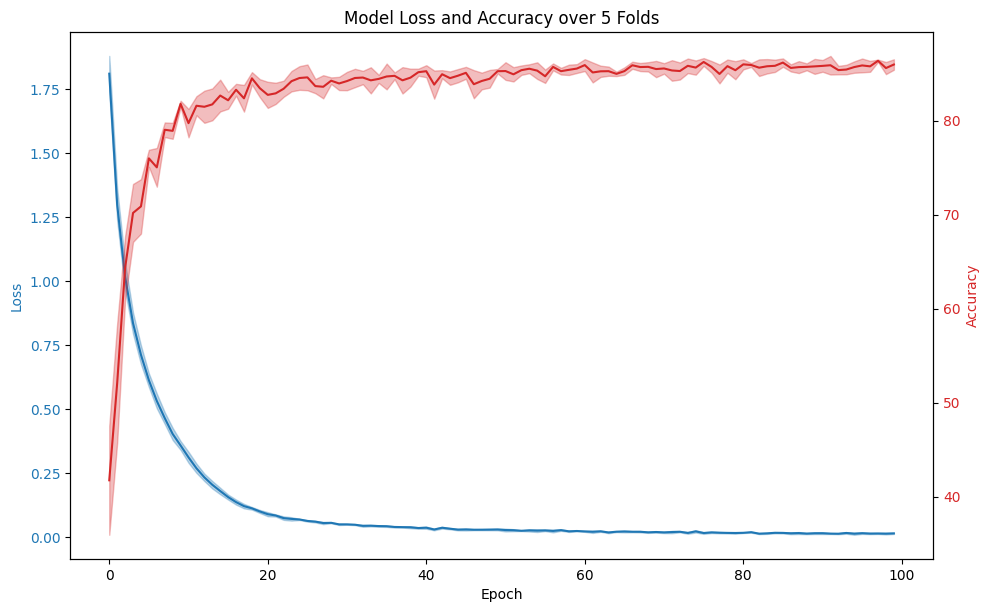

In [43]:
# use pre-processed result
loss_k = [[1.804732616336201, 1.3061241284726908, 1.0155662875205944, 0.8438166665573852, 0.7223711739332912, 0.6202041138284884, 0.5321137772771878, 0.46896745964361075, 0.4090248798124326, 0.3528590689832791, 0.30781614154386827, 0.26363265723846974, 0.23419247193934437, 0.2064783418902193, 0.18066511922084486, 0.153163228053064, 0.1363651534667411, 0.11520411917410148, 0.11132073645203258, 0.102517316820094, 0.08834299154151172, 0.08692233284828238, 0.08096988503032694, 0.0631892029240656, 0.06600645518662354, 0.06363609148979413, 0.06208933288002381, 0.05362312337785317, 0.056635710359446874, 0.04702379322162987, 0.048765946907875016, 0.04935427889962065, 0.04239163817908502, 0.04583457491089837, 0.04078759321870026, 0.04005614913309725, 0.03808796716543039, 0.038774771050523266, 0.03611175351521036, 0.038185794422694576, 0.038733149255040476, 0.032248734960335486, 0.030493983811439987, 0.028527315391265542, 0.02305368189646947, 0.034968921355819464, 0.027336414769692077, 0.026378988426330442, 0.02875283735306984, 0.03109487356774631, 0.028322832706726912, 0.023120046145719338, 0.022858378895215865, 0.034008891023427676, 0.02330431596453364, 0.022006186960151972, 0.019313610846264335, 0.028420859650439455, 0.021488962182617068, 0.023771673976401866, 0.018714392900291366, 0.027586650717718982, 0.02555187856414007, 0.0163291162421061, 0.02199284882082369, 0.0163089281528655, 0.019305704524741507, 0.02271964094921342, 0.016666134182126084, 0.015043727171227723, 0.01479346975970555, 0.023360578316121032, 0.018197135205347888, 0.02096404502243475, 0.014989112112540495, 0.020749759294590397, 0.01578692265921475, 0.014623114585182761, 0.017987363297662796, 0.011555544469426362, 0.014589957943896186, 0.017037897365815926, 0.012472378749090927, 0.010642314160129888, 0.019538178735527212, 0.013980695591693128, 0.015927288666472694, 0.009749850347338399, 0.01719075558898571, 0.009682118247933823, 0.016122508747089384, 0.011742944777410457, 0.010614167039290105, 0.01953916270029443, 0.008474637398319265, 0.014942688219654169, 0.01514213597951044, 0.013774310536032187, 0.008806032277367868, 0.012655057271505659], [1.8934052874105045, 1.3587117145617549, 1.0751297045439576, 0.8780288212596418, 0.7505675641873393, 0.6420915553364129, 0.5707543180963863, 0.4920145282730127, 0.42914323351634576, 0.3774079870872985, 0.3442719534467965, 0.29377120116743416, 0.24701956733347127, 0.22307608900264428, 0.19119086816383246, 0.16905969536056914, 0.14835940532909986, 0.13415601651984663, 0.12083471632494142, 0.1066763402816777, 0.09882814400255109, 0.0838607010868982, 0.08093478864790818, 0.08075917044434304, 0.06805391717380799, 0.06488790444154947, 0.06148401928393129, 0.05953157826671942, 0.055741275883854004, 0.04524326178181274, 0.050031389634961045, 0.04922037528040774, 0.04979809221049872, 0.03862627336759858, 0.04777145856573357, 0.044125463314965876, 0.03670142359582309, 0.035340167073136454, 0.03428266084068247, 0.03279518492772027, 0.038246651540213554, 0.029799973214463222, 0.03755561336486291, 0.033328760027946436, 0.03037735110426994, 0.032418090926268295, 0.03104189704038417, 0.031803230176208924, 0.028260838904519588, 0.025663359713582204, 0.019694050800036854, 0.027066439071202653, 0.02365900015103454, 0.024489134453717223, 0.028396643867445424, 0.023342546410880946, 0.021498513462354082, 0.029824389605278955, 0.02179500622567055, 0.02159520544683182, 0.02280375375214582, 0.018807382631378666, 0.020209896366875143, 0.0170291603572898, 0.02288296077069053, 0.027076446168158522, 0.017458422696954325, 0.022333192357731336, 0.017993302767027576, 0.01912744045844643, 0.015786155909921443, 0.017925012729811046, 0.02229798953781595, 0.013208968380481724, 0.029146884675292053, 0.014556733481275879, 0.01794575536407643, 0.013804797870145815, 0.01792798965066678, 0.019262381027292344, 0.01567769103088193, 0.016775710774520423, 0.01288451223256717, 0.012102727900000377, 0.015981605189653712, 0.019877580730315765, 0.015186082671981115, 0.01687536501984827, 0.012925917940180942, 0.013757023586828572, 0.013633969631903132, 0.016047541778768968, 0.0100867288829017, 0.013031250161173132, 0.017093926007903017, 0.013542046690211612, 0.01283457918781988, 0.010701640099930014, 0.013064395521093237, 0.018086985423235075], [1.8827085384545617, 1.3676533942786269, 1.0774775494020967, 0.8759224868049256, 0.7434116181093283, 0.6359671766575152, 0.5500822923244378, 0.482226697400736, 0.422361648454072, 0.3758186099533075, 0.3177989975046426, 0.2819161131359137, 0.24765537019830924, 0.21269336716530804, 0.19250786966218736, 0.16043338358116607, 0.1418640211034126, 0.12319576451049065, 0.11051348763437698, 0.10135961650385739, 0.09625331824199079, 0.0873501699048871, 0.06749226051433303, 0.07529749257710223, 0.06954450318560051, 0.0650499053715993, 0.06256070220842957, 0.052176948802652785, 0.053100960542851044, 0.052182149646555286, 0.05132999950156997, 0.04713309152623097, 0.044461189309498085, 0.043159715473479306, 0.042284385140497274, 0.042692526708079576, 0.03705003158637165, 0.040913408668637394, 0.03687777710794367, 0.03798718536837985, 0.03981843716933574, 0.03237380514839313, 0.034553337828789915, 0.029593026413903618, 0.031809236872167634, 0.024259417443056427, 0.029090240025504553, 0.027681279686200003, 0.024233696921825254, 0.02455353398073521, 0.034518537909657615, 0.02253305685974973, 0.02622214722948836, 0.020502870932917673, 0.03265919402437344, 0.02530717562998276, 0.03409582841667174, 0.021700709113813905, 0.018110060714779497, 0.02327824097394329, 0.021501811113241634, 0.021332613451225228, 0.020919868513275444, 0.013995293087402052, 0.019738251172837774, 0.02139550585149283, 0.019835530609160372, 0.020826476091960346, 0.021638761832254765, 0.021413141845820508, 0.020289661252581793, 0.011714700977299857, 0.022303838178868027, 0.016375506568602722, 0.02027286212571849, 0.015400028233697188, 0.01365458067594793, 0.020928764830328968, 0.016211332015337247, 0.014324810391342955, 0.01610482530921758, 0.02046412927198855, 0.01587419473464205, 0.01563036627447991, 0.013734232632481153, 0.014930866377351533, 0.014477102092270867, 0.011577420511335562, 0.010694882829954096, 0.012808471569516809, 0.018495401911550812, 0.012340660752368178, 0.015321549656831145, 0.01226842317692135, 0.012173123925158768, 0.014456467233877323, 0.015628172902409143, 0.015095460591652727, 0.013033087126233859, 0.013446242196684548], [1.7568120689818654, 1.2610968456100733, 0.9767667765434558, 0.8076093794819647, 0.6906178774544225, 0.5918931573534164, 0.5168571878736392, 0.44982770685189827, 0.3863701065793967, 0.34891342269345976, 0.30770419133356963, 0.26097304604876154, 0.2262770033682497, 0.1964153125644111, 0.17418621904172074, 0.1559625944128623, 0.1342604776350454, 0.12099140875350933, 0.11073894765430366, 0.09744121287815487, 0.08214382754085353, 0.08491444835117973, 0.07356659162004059, 0.06759622504119389, 0.06551392359165148, 0.06039819287987182, 0.058210518260221604, 0.04760200038445167, 0.056950421884846385, 0.05023312231246085, 0.04749774092997308, 0.047732894761136735, 0.04007025453754472, 0.04715919063111154, 0.041107617454758036, 0.04452134389839412, 0.043619808266884066, 0.03721768481113141, 0.04473225259223578, 0.03130954267872206, 0.028215535854275067, 0.025616246383046187, 0.04062031269647752, 0.035053661004781494, 0.029128814622694357, 0.028877145680766284, 0.027732904834937625, 0.026244875029032194, 0.03212293379098778, 0.03317216376364142, 0.021735242387800946, 0.03343197962673851, 0.023443341110738147, 0.0242832409646933, 0.017818882721135937, 0.030581075278130886, 0.01943251656412728, 0.02722474140776753, 0.021464570770373035, 0.021880980598874732, 0.023796236380832805, 0.019032088442415555, 0.019814013829154906, 0.02266702054187651, 0.018885849949618512, 0.01915082199330339, 0.020177656280218264, 0.019103341113537745, 0.017662898658612723, 0.017728272855792124, 0.015685341344538094, 0.02409488120283292, 0.021267326410266404, 0.010871037156298792, 0.021087063574052704, 0.014752182794307855, 0.02021437678755877, 0.016547341529134334, 0.012366952373304811, 0.013365023218720337, 0.017103785017537645, 0.021123748782869392, 0.010287819611491727, 0.016234785655898868, 0.013568608181143785, 0.015589668907171852, 0.007489704265700506, 0.020057808830953813, 0.013105796928188918, 0.016432291479628686, 0.014986602506546761, 0.012692628679523216, 0.013652584107743091, 0.013386642685169897, 0.017774840992873166, 0.010408658534753324, 0.009378793503992856, 0.015827662821810955, 0.017975990877233106, 0.011601410506272442], [1.715405396379221, 1.200147349423113, 0.9387489528701709, 0.7700763446644853, 0.6514147474362065, 0.5717329853258956, 0.4866388929537691, 0.4284191733827225, 0.3648581890918957, 0.33181481836988524, 0.2773391909111803, 0.24117213128188167, 0.20851328171575412, 0.1801696878890641, 0.1579254082145211, 0.1393835286910351, 0.11883840969980905, 0.10777938207641197, 0.10490807411246025, 0.0891377755646079, 0.07808320047839666, 0.07549031080600743, 0.064018671615079, 0.06450884346627056, 0.07157156221753064, 0.058208119187030956, 0.05401241790411024, 0.05796637852786305, 0.05292746474216588, 0.049895501871126145, 0.047359885575365836, 0.04478887131901833, 0.03957516481295026, 0.044405691495638326, 0.03979257095144681, 0.03738796096830703, 0.03876882270104981, 0.03866808228685666, 0.036377004573877436, 0.03317656145042802, 0.0348312181326525, 0.02487010098820829, 0.03587693054978096, 0.03376687967092745, 0.028133982335668824, 0.024995117362167616, 0.02525258310285721, 0.02864379690422233, 0.029170605313842194, 0.03057694789340211, 0.02971015124234554, 0.024887989632086178, 0.02368709873188638, 0.024220958621926997, 0.020265176099398787, 0.02611138742536488, 0.022305111753236958, 0.025191257640245383, 0.02609140637932128, 0.024743498906365985, 0.020514346773739155, 0.013499605789024755, 0.023192225226901095, 0.01677039127002391, 0.018538108073106054, 0.021967196566718125, 0.02409374693601735, 0.015561503373945991, 0.015275162987665517, 0.02234268795985317, 0.021425212518981145, 0.017707683822873178, 0.016542569597609885, 0.01645647424306016, 0.022598441884797715, 0.010328667729051774, 0.020765750331075816, 0.01602711459057749, 0.013859928475008323, 0.017814362351127086, 0.01641385598167182, 0.016639989800090155, 0.011892793979897917, 0.014763940133096, 0.01739455641296799, 0.013892082285701835, 0.017354130197772773, 0.01683309613749349, 0.010708355985787439, 0.018856980765261464, 0.00876248743203503, 0.011470065439280239, 0.01249871155187211, 0.018720361232345557, 0.00731701844160097, 0.01930737074609916, 0.012283210156297332, 0.01143464047499482, 0.010793403647812302, 0.013095566712911877]]
acc_k = [[43.38, 52.73, 63.41, 64.45, 67.23, 76.85, 73.21, 80.04, 78.97, 81.25, 79.34, 82.52, 83.84, 83.05, 79.64, 83.23, 83.64, 82.7, 84.51, 82.67, 82.39, 83.09, 83.59, 84.98, 84.14, 84.91, 84.13, 85.61, 84.18, 82.95, 83.43, 85.26, 83.67, 84.58, 84.82, 85.99, 84.75, 85.6, 82.67, 85.48, 84.09, 85.3, 84.66, 85.34, 85.45, 85.56, 82.63, 84.4, 85.04, 84.96, 87.03, 85.44, 85.16, 86.15, 86.51, 85.72, 86.02, 85.76, 85.95, 85.73, 85.61, 84.56, 85.78, 84.77, 85.21, 84.74, 85.8, 85.98, 86.1, 85.78, 85.9, 85.96, 84.19, 85.26, 85.92, 86.13, 84.9, 84.55, 86.01, 85.32, 85.33, 86.21, 85.86, 85.59, 86.01, 85.95, 86.01, 85.89, 86.14, 86.54, 85.83, 86.77, 84.51, 85.97, 86.16, 85.43, 84.98, 86.27, 86.56, 86.31], [39.33, 44.05, 64.88, 72.83, 68.28, 75.97, 72.88, 78.72, 79.03, 82.07, 77.87, 79.77, 80.88, 82.99, 83.26, 81.83, 83.31, 83.27, 84.61, 84.27, 84.72, 84.0, 84.03, 83.45, 85.18, 84.58, 84.8, 81.95, 83.6, 84.15, 85.37, 84.45, 85.51, 83.41, 84.33, 83.5, 85.21, 85.11, 85.09, 84.81, 85.66, 84.73, 84.33, 84.51, 83.51, 85.27, 84.26, 83.55, 85.18, 85.19, 84.87, 85.53, 85.61, 85.08, 84.41, 84.64, 85.94, 85.06, 85.71, 84.79, 85.39, 85.7, 86.09, 84.92, 85.07, 85.7, 86.34, 85.92, 86.35, 86.27, 86.12, 83.23, 86.02, 86.89, 84.59, 86.19, 86.36, 83.22, 84.8, 85.19, 85.89, 85.81, 85.44, 84.36, 85.71, 86.57, 85.2, 85.08, 85.25, 85.04, 85.93, 86.92, 85.83, 85.29, 86.07, 85.89, 86.3, 86.59, 85.74, 85.86], [31.69, 48.76, 58.42, 69.55, 70.82, 76.5, 75.09, 78.99, 77.38, 82.09, 78.72, 82.55, 78.67, 80.48, 82.12, 81.7, 83.58, 82.79, 83.94, 83.98, 83.59, 81.4, 84.5, 82.76, 85.28, 82.15, 82.98, 83.83, 84.58, 84.67, 84.57, 82.82, 83.83, 82.07, 84.04, 82.67, 84.84, 81.79, 84.88, 85.23, 85.09, 84.35, 84.88, 83.26, 84.73, 84.84, 85.01, 85.38, 82.73, 85.11, 84.5, 84.43, 84.69, 85.48, 84.2, 83.7, 85.24, 84.74, 84.45, 85.39, 85.38, 83.31, 84.99, 84.9, 85.19, 84.94, 85.82, 85.01, 85.62, 83.84, 84.88, 85.59, 84.69, 84.94, 85.0, 85.7, 85.08, 85.56, 85.18, 85.9, 85.5, 85.75, 84.03, 86.34, 86.6, 85.63, 86.02, 85.96, 85.34, 85.74, 84.65, 84.49, 85.45, 84.53, 86.1, 84.79, 85.15, 86.28, 84.68, 84.93], [47.04, 51.65, 68.03, 71.6, 75.03, 74.26, 78.66, 79.61, 79.98, 81.55, 82.21, 81.62, 82.35, 83.12, 84.32, 80.9, 83.81, 79.6, 85.65, 84.35, 80.55, 81.81, 82.6, 85.81, 85.8, 86.37, 83.72, 82.75, 84.43, 84.67, 84.93, 85.68, 84.99, 85.64, 85.05, 86.06, 84.12, 83.71, 85.18, 85.6, 85.88, 83.76, 85.57, 84.45, 85.43, 85.77, 85.75, 82.91, 84.16, 85.38, 85.42, 83.66, 86.18, 85.95, 85.94, 85.25, 86.07, 85.52, 85.77, 85.54, 87.06, 85.82, 84.48, 85.89, 84.64, 85.73, 86.21, 86.18, 84.91, 86.06, 85.98, 86.36, 86.63, 86.61, 86.72, 86.98, 86.39, 86.11, 86.7, 86.66, 86.63, 86.11, 86.55, 86.32, 86.17, 86.81, 85.15, 86.63, 86.06, 84.75, 86.39, 86.33, 85.51, 85.78, 85.6, 86.94, 86.23, 86.3, 85.12, 86.47], [47.25, 63.22, 66.96, 72.46, 73.01, 76.35, 75.3, 77.78, 79.19, 81.96, 80.51, 81.44, 81.62, 78.99, 83.99, 83.15, 82.07, 83.5, 83.78, 81.96, 82.44, 84.2, 82.22, 83.98, 82.26, 84.99, 82.73, 83.85, 84.44, 83.32, 82.74, 84.46, 84.91, 85.72, 83.95, 85.26, 84.9, 85.22, 85.02, 84.63, 85.56, 81.01, 85.23, 85.03, 84.77, 83.98, 81.71, 84.84, 85.15, 85.64, 84.54, 85.56, 85.18, 84.94, 85.52, 84.28, 85.3, 85.21, 85.13, 86.23, 86.09, 86.22, 84.88, 85.81, 84.75, 85.22, 85.27, 85.4, 85.62, 85.47, 84.86, 85.53, 84.84, 85.45, 85.97, 86.19, 85.83, 85.38, 86.28, 83.74, 86.57, 85.7, 86.27, 86.29, 84.66, 85.9, 85.64, 84.89, 85.81, 86.77, 86.31, 84.94, 85.56, 85.59, 84.55, 86.3, 86.2, 86.39, 85.85, 86.26]]

draw_loss(loss_k, acc_k)

<img src="./images/CNNloss.png" alt="示例图片" width="700">

### Find the best model
**Due to the significant time and computational resources required for this step, I have commented out the training process here.**

In [44]:
# k_folds = 5
# test_accuracies = []

# for fold in range(k_folds):
#     # instantiate model
#     model = CNN().to(device)
    
#     # load saved best acc model of each folds.
#     model.load_state_dict(torch.load(f'model_CNN_checkpoints/best_CNN_model_fold_{fold + 1}.pth'))
#     model.eval()

#     # evaluate model in test-set
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in testloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     test_accuracy = 100 * correct / total
#     test_accuracies.append(test_accuracy)
#     print(f'Test Accuracy for fold {fold + 1}: {test_accuracy:.2f}%')

# average_test_accuracy = np.mean(test_accuracies)
# print(f'Average Test Accuracy across folds: {average_test_accuracy:.2f}%')


Test Accuracy for fold 1: 85.95%
Test Accuracy for fold 2: 86.90%
Test Accuracy for fold 3: 86.08%
Test Accuracy for fold 4: 86.30%
Test Accuracy for fold 5: 86.36%
Average Test Accuracy across folds: 86.32%



In [46]:
# Load model
model = CNN().to(device)

# Load saved model in the 5-th fold
model_path = 'models/best_CNN_model_fold_2.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))

# evaluate model in test-set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 86.90%


## <a id='toc2_5'></a>[Method 1.5: Vision Transformer](#toc0_)

The [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) is a model that applies the Transformer architecture to computer vision tasks, such as image classification. Traditional Convolutional Neural Networks (CNNs) excel at capturing local features in images, while Transformers are inherently designed for sequence-to-sequence tasks, making them adept at extracting global contextual relationships. ViT divides input images into patches, transforms these patches into a sequence of embeddings, and processes them through a Transformer architecture.

<img src="./images/ViT.png" alt="示例图片" width="800">

#### Patch Embedding

Initially, the input image is divided into patches of size $p \times p$, and each patch is flattened into a vector. These embedded patches serve as the input to the Transformer.

$$
x_{\text{patch}} = \text{Flatten}(\text{Conv2d}(x))
$$

Here, the `Conv2d` operation effectively segments the image into patches of size $p \times p$ and generates embeddings for each patch.

#### Multi-head Self-Attention

The core of the Transformer is the multi-head self-attention mechanism. In ViT, each patch embedding undergoes linear transformations to produce Query (Q), Key (K), and Value (V) matrices:

$$
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
$$

Self-attention is computed as follows:

$$
\text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where $d_k$ is the dimension of the key vectors, and the scaling factor $\frac{1}{\sqrt{d_k}}$ is used to stabilize gradients. The multi-head mechanism computes multiple attention heads independently and then concatenates their outputs:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \ldots, \text{head}_h) W_O
$$

#### Multi-Layer Perceptron (MLP)

Each Transformer block also includes an MLP layer, typically consisting of two linear transformations with a GELU activation function:

$$
\text{MLP}(x) = \text{GELU}(xW_1 + b_1) W_2 + b_2
$$

#### Class Token and Position Embedding

To facilitate classification tasks, ViT introduces a class token ([CLS]) into the sequence of patch embeddings:

$$
X_0 = [\text{CLS}] + X_{\text{patch}} + \text{Position Embedding}
$$

Position embeddings are added to retain positional information within the input sequence:

$$
X_{\text{input}} = X_{\text{patch}} + \text{Position Embedding}
$$

#### Complete Model Architecture

In ViT, multiple Transformer blocks are stacked sequentially. The final class token is processed through a classification head for image classification:

$$
y = \text{MLP}(\text{LayerNorm}(X_{\text{CLS}}))
$$


### Define Hyperparameters

In [48]:
# Model parameters
patch_size = 2
embed_dim  = 96
depth = 5
n_heads = 12
mlp_ratio = 4.0
qvv_bias = True


# Training parameters
batch_size = 32
learning_rate = 3e-4
dropout =  0.2
attn_dropout = 0.2
step_size=10
gamma= 0.1
n_epochs = 50
data_augmentation = False

### Define Model

In [52]:
# Patch Embedding Class
class Patchembed(nn.Module):
    def __init__(self, img_size, patch_size, in_chan, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.view(x.shape[0], self.proj.out_channels, -1)
        x = x.permute(0,2,1)
        return x


# Multiheaded Attention Class:
class Attention(nn.Module):
    def __init__(self,dim=96,n_heads=8,qkc_bias=True,attn_p=0.,proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim  = dim // n_heads
        self.scale = self.head_dim**-.5
        
        self.qvk = nn.Linear(dim,3*dim,bias=qkc_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim,dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self,x):
        n_samples, n_tokens, dim = x.shape

        qkv = self.qvk(x)
        qkv = qkv.reshape(n_samples,n_tokens,3,self.n_heads,self.head_dim)
        qkv = qkv.permute(2,0,3,1,4)
        q,k,v = qkv[0], qkv[1], qkv[2]

        out = q@k.transpose(-2,-1)*self.scale
        out = self.attn_drop(out)
        out = F.softmax(out,dim=-1)@v
        out = out.transpose(1,2)
        out = out.reshape(n_samples,n_tokens,-1)
        x = self.proj(out)
        x = self.proj_drop(x)

        return(x)
    
# Multilayer Perceptron Class
class MLP(nn.Module):
    def  __init__(self,in_features,hidden_features,out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features,hidden_features)
        self.act= nn.GELU()
        self.fc2 = nn.Linear(hidden_features,out_features)
        self.drop = nn.Dropout(p)
    def forward(self,x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x



# Encoder Block
class Block(nn.Module):

    def __init__(self, dim, n_heads, mlp_ratio=4.0,qkv_bias=True,p=0.,attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim,n_heads,qkc_bias=qkv_bias,attn_p=attn_p,proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim*mlp_ratio)
        self.mlp = MLP(dim,hidden_features,dim)

    def forward(self,x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


# Vision Transformer Class
class Visiontransformer(nn.Module):
    def __init__(self,img_size=32,patch_size=patch_size,in_chans=3,n_classes=10,embed_dim=embed_dim,depth=depth,n_heads=n_heads,mlp_ratio=mlp_ratio,qvv_bias=qvv_bias,p=dropout,attn_p=attn_dropout):
        super().__init__()
        self.n_patches = int((img_size // patch_size) ** 2)
        self.patch_embed = Patchembed(img_size=img_size,patch_size=patch_size,in_chan=in_chans,embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,1+self.n_patches,embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList([Block(dim=embed_dim,n_heads=n_heads,mlp_ratio=mlp_ratio,qkv_bias=qvv_bias,p=p,attn_p=attn_p) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim,n_classes)
        
    def forward(self,x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        x = torch.cat((cls_token,x),dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:,0]
        x = self.head(cls_token_final)

        return x
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model = Visiontransformer()
print(model)


Visiontransformer(
  (patch_embed): Patchembed(
    (proj): Conv2d(3, 96, kernel_size=(2, 2), stride=(2, 2))
  )
  (pos_drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-4): 5 x Block(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qvk): Linear(in_features=96, out_features=288, bias=True)
        (attn_drop): Dropout(p=0.2, inplace=False)
        (proj): Linear(in_features=96, out_features=96, bias=True)
        (proj_drop): Dropout(p=0.2, inplace=False)
      )
      (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=384, out_features=96, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=96, out_features=10, bias=True)
)


### Train model

**Due to the significant time and computational resources required for training, I have commented out the training process here.**

**Due to the large model size, we will train for only 50 epochs.**


In [51]:
# # path to save model
# os.makedirs('./model_ViT_checkpoints', exist_ok=True)

# # K Fold cross validation
# k_folds = 5
# kfold = KFold(n_splits=k_folds, shuffle=True)

# best_fold_accuracies = []
# loss_k = []
# train_acc_k = []
# val_acc_k = []
# for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):
#     print(f'Fold {fold + 1}/{k_folds}')
    
#     # Data loader
#     train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
#     val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
#     valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)

#     # Initialize model
#     model = Visiontransformer().to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#     scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
#     criterion = nn.CrossEntropyLoss()

#     best_val_acc = 0.0  # best acc

#     loss_i = []
#     train_acc_i = []
#     val_acc_i = []
#     for epoch in range(n_epochs):
#         start_time = time.time()
#         # train
#         model.train()
#         train_loss, train_correct = 0.0, 0
#         for images, labels in trainloader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             _, preds = torch.max(outputs, 1)
#             train_correct += (preds == labels).sum().item()

#         train_acc = train_correct / len(train_sampler)

#         # evaluate
#         model.eval()
#         val_correct = 0
#         with torch.no_grad():
#             for images, labels in valloader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 _, preds = torch.max(outputs, 1)
#                 val_correct += (preds == labels).sum().item()

#         val_acc = val_correct / len(val_sampler)
#         end_time = time.time()
#         time_long = end_time - start_time
#         print(f'Fold {fold + 1}, Epoch {epoch + 1}/{n_epochs},Loss: {train_loss/len(train_loader)}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Time: {time_long} secs')
#         loss_i.append(train_loss/len(train_loader))
#         train_acc_i.append(train_acc)
#         val_acc_i.append(val_acc)
        
#         # save better one
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             torch.save(model.state_dict(), f'./data/model_ViT_checkpoints/best_ViT_model_fold_{fold + 1}.pth')
#             # print(f'New best model saved for fold {fold + 1} with val accuracy: {best_val_acc:.4f}')

#     best_fold_accuracies.append(best_val_acc)
#     print(f'Best Validation Accuracy for fold {fold + 1}: {best_val_acc:.4f}')
#     loss_k.append(loss_i)
#     train_acc_k.append(train_acc_i)
#     val_acc_k.append(val_acc_i)

# print(f'Average Best Validation Accuracy across folds: {np.mean(best_fold_accuracies):.4f}')


Fold 1/5
Fold 1, Epoch 1/50,Loss: 7.349329643737013, Train Acc: 0.3070, Val Acc: 0.4032, Time: 80.81147742271423 secs
Fold 1, Epoch 2/50,Loss: 6.040249907551482, Train Acc: 0.4420, Val Acc: 0.4916, Time: 80.64023184776306 secs
Fold 1, Epoch 3/50,Loss: 5.419871328356929, Train Acc: 0.5062, Val Acc: 0.5401, Time: 81.07023358345032 secs
Fold 1, Epoch 4/50,Loss: 5.035770037494148, Train Acc: 0.5438, Val Acc: 0.5530, Time: 80.67810392379761 secs
Fold 1, Epoch 5/50,Loss: 4.795717018100019, Train Acc: 0.5656, Val Acc: 0.5758, Time: 80.70142650604248 secs
Fold 1, Epoch 6/50,Loss: 4.53271712834081, Train Acc: 0.5912, Val Acc: 0.6079, Time: 80.45239925384521 secs
Fold 1, Epoch 7/50,Loss: 4.361794854124514, Train Acc: 0.6065, Val Acc: 0.6112, Time: 80.65066242218018 secs
Fold 1, Epoch 8/50,Loss: 4.20591686061396, Train Acc: 0.6214, Val Acc: 0.6207, Time: 80.4897837638855 secs
Fold 1, Epoch 9/50,Loss: 4.038664959680539, Train Acc: 0.6389, Val Acc: 0.6388, Time: 80.55987501144409 secs
Fold 1, Epoc

### Visual training process

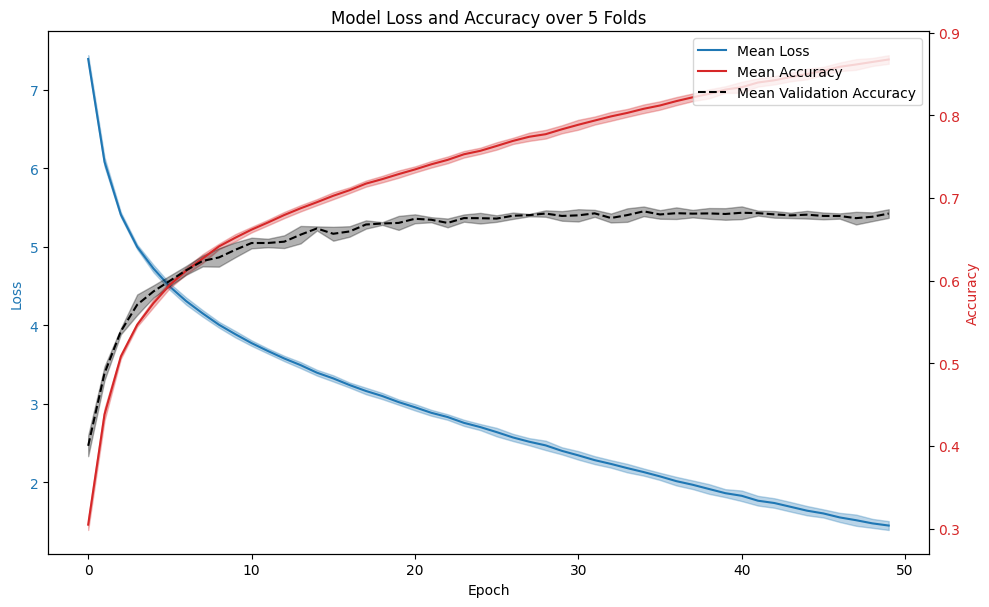

In [58]:
def draw_loss_3(loss_data, acc_data, trials=5, val_acc=None):
    N = len(loss_data[0])

    loss_mean = np.mean(loss_data, axis=0)
    loss_std = np.std(loss_data, axis=0)
    acc_mean = np.mean(acc_data, axis=0)
    acc_std = np.std(acc_data, axis=0)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color_loss = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color_loss)
    ax1.plot(range(N), loss_mean, color=color_loss, label='Mean Loss')
    ax1.fill_between(range(N), loss_mean - loss_std, loss_mean + loss_std, color=color_loss, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor=color_loss)

    ax2 = ax1.twinx()
    color_acc = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color_acc)
    ax2.plot(range(N), acc_mean, color=color_acc, label='Mean Accuracy')
    ax2.fill_between(range(N), acc_mean - acc_std, acc_mean + acc_std, color=color_acc, alpha=0.3)
    ax2.tick_params(axis='y', labelcolor=color_acc)

    if val_acc is not None:
        val_acc_mean = np.mean(val_acc, axis=0)
        val_acc_std = np.std(val_acc, axis=0)
        color_val_acc = 'black'
        ax2.plot(range(N), val_acc_mean, color=color_val_acc, linestyle='--', label='Mean Validation Accuracy')
        ax2.fill_between(range(N), val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color=color_val_acc, alpha=0.3)

    fig.tight_layout()
    plt.title('Model Loss and Accuracy over {} Folds'.format(trials))
    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()
    
# using pre-processed results
loss_k = [[7.349329643737013, 6.040249907551482, 5.419871328356929, 5.035770037494148, 4.795717018100019, 4.53271712834081, 4.361794854124514, 4.20591686061396, 4.038664959680539, 3.904166247231511, 3.8083360690278365, 3.69099976070011, 3.5971041743557293, 3.5048574675767186, 3.403141270144679, 3.321494793834778, 3.249016472135489, 3.175815982083543, 3.10857345225712, 3.0371692097796417, 2.9598726074154764, 2.897807747506486, 2.8515189529988714, 2.787657224427397, 2.7230056578549333, 2.6530915842459986, 2.595220899239135, 2.5452008135973836, 2.5123157943494783, 2.4206346648569688, 2.3958415306223846, 2.3280180870724942, 2.246764940718492, 2.2293836648186174, 2.1738346906991812, 2.1172126343075077, 2.0544576972437363, 2.020837565961356, 1.967414891043791, 1.9041171480958072, 1.8949992449614947, 1.8238029213140186, 1.7914315606363285, 1.739136724807203, 1.688179674763649, 1.6678522208961435, 1.6049910543349604, 1.569734089183636, 1.5308381846299568, 1.4937477048498373], [7.3686791852640265, 6.0044365957522166, 5.353430871575023, 4.967267000827546, 4.682396051030571, 4.454736037757069, 4.27030228025997, 4.121692145023102, 3.9680441660812487, 3.835639811838016, 3.72131819904041, 3.630660916384036, 3.5302090457262705, 3.4515000332277803, 3.3453990195315484, 3.269604623127288, 3.187552689077755, 3.114785110893341, 3.0554354081329067, 2.989351774271304, 2.9020978774125585, 2.8369509950518226, 2.7884095622042118, 2.7157680535564026, 2.653053354483824, 2.5735531664504028, 2.5211141248004507, 2.4681001932095414, 2.4045482374513494, 2.3514210060476874, 2.298077009451656, 2.2282260127437, 2.2039718671252553, 2.1342031038321627, 2.099058076025198, 2.0301080541060377, 1.9621103390956078, 1.91812172155982, 1.8680759516720193, 1.8300689075130243, 1.7671155617259944, 1.7064644804539773, 1.6777400699334022, 1.6249190322316873, 1.6039813392030926, 1.5685285418606794, 1.5043934715774874, 1.4724117504855314, 1.4221723644068827, 1.416823155713824], [7.37927668277448, 6.081957480206657, 5.432812102115192, 5.02267556735121, 4.753651416339813, 4.533054348188467, 4.342220277260668, 4.193271599067286, 4.036953483717129, 3.9378991782093964, 3.800229700419088, 3.686226675209527, 3.603370171766312, 3.528535077175774, 3.422827112598541, 3.355623065758818, 3.2645691118110864, 3.1881963279300605, 3.1319415815912497, 3.0435749224770947, 2.981417179202881, 2.912031964181711, 2.864799406105718, 2.785075359403516, 2.735405324985044, 2.6833029811660323, 2.606916320638154, 2.5653678214968965, 2.5198699903373902, 2.4364014869204724, 2.3962746062122595, 2.330418798346489, 2.279927075861361, 2.222025846520933, 2.1728458181261634, 2.115096117170474, 2.0601874115272834, 2.023350044466055, 1.969577680332973, 1.9180888333997597, 1.8862446992161175, 1.8179819271825373, 1.7990653331573017, 1.7627561822200355, 1.6892825141073036, 1.6296348814099741, 1.6128652824666172, 1.5830735797984912, 1.54549675372938, 1.5115645254215302], [7.365990836018572, 6.1105320461261, 5.398906371083123, 4.961798630392971, 4.667878734798858, 4.431673130478722, 4.239516503132951, 4.096588594273637, 3.957853387719907, 3.842231414855098, 3.742009641549077, 3.6405036909321247, 3.543688051521588, 3.4446306738038412, 3.3672702838056767, 3.295728045816239, 3.2190164505673673, 3.1196081533599584, 3.0537186550160946, 2.9767868465508895, 2.9251826380769286, 2.8499786922345147, 2.791011171123852, 2.70619259907986, 2.6633782735267006, 2.5839037087778696, 2.5144389217463545, 2.457208214190821, 2.3928743219984985, 2.344272865559727, 2.2635762829083603, 2.21617019276459, 2.159986730581655, 2.1001890416676625, 2.058672270930994, 2.0125208254725027, 1.9389522287268608, 1.8918258629191798, 1.8192383650773631, 1.7809826502213464, 1.7317976496947078, 1.6790329742307861, 1.6527861495749256, 1.6105655874259555, 1.540765544715019, 1.5237590250449058, 1.4668930467610923, 1.4011331984933955, 1.4034226255747266, 1.35822211822477], [7.484382637773459, 6.169754946574616, 5.436020501695883, 5.004862456847303, 4.709047388535338, 4.505900189708978, 4.325674264956587, 4.14627310214713, 4.038413952143428, 3.918384250646201, 3.7956977631337345, 3.716514954361291, 3.61442393140671, 3.5378140186349425, 3.4469789744566044, 3.3790173356335003, 3.2773675857641447, 3.22288949839985, 3.1498209497037406, 3.0668363793970297, 3.0169660277640857, 2.9362732065847506, 2.8670302508547665, 2.7980345898923784, 2.748383511321994, 2.7098855311973407, 2.6257565954146673, 2.5537800488475795, 2.5290235403818064, 2.4561259835101543, 2.3698755017579933, 2.316945618952806, 2.2876670266778323, 2.225064194383332, 2.1557238217169483, 2.110440154949697, 2.066641955329968, 1.998171662036984, 1.958919942474213, 1.8835960379280983, 1.8700548134767971, 1.809579934817724, 1.7690214139346878, 1.7106347796016228, 1.6810747703995568, 1.6378218436155456, 1.5847769429722725, 1.5707141680363268, 1.4934496095243353, 1.4755328569216088]]
train_acc_k = [[0.30695, 0.44205, 0.506225, 0.54385, 0.565625, 0.591175, 0.6065, 0.621425, 0.638925, 0.6516, 0.65815, 0.6683, 0.6763, 0.6868, 0.69565, 0.702475, 0.707525, 0.717275, 0.722875, 0.72905, 0.733175, 0.74035, 0.74315, 0.7489, 0.755925, 0.762775, 0.76635, 0.7716, 0.775525, 0.780625, 0.78275, 0.7886, 0.799225, 0.800175, 0.805075, 0.807375, 0.8144, 0.817575, 0.820175, 0.82975, 0.8273, 0.834725, 0.838475, 0.84235, 0.845275, 0.848775, 0.853775, 0.856625, 0.859925, 0.864825], [0.309025, 0.448825, 0.51315, 0.550125, 0.57805, 0.597575, 0.6182, 0.631325, 0.646775, 0.656375, 0.66695, 0.6748, 0.684625, 0.692225, 0.6982, 0.707225, 0.71545, 0.720725, 0.7259, 0.732175, 0.738175, 0.74615, 0.751075, 0.754975, 0.76275, 0.767525, 0.7714, 0.778175, 0.78275, 0.787975, 0.7942, 0.79935, 0.8029, 0.807275, 0.809775, 0.816875, 0.8221, 0.825075, 0.829475, 0.8334, 0.83975, 0.8436, 0.845225, 0.85225, 0.853825, 0.856875, 0.86285, 0.864775, 0.869425, 0.869925], [0.30695, 0.439525, 0.5077, 0.546025, 0.5695, 0.59195, 0.6098, 0.61955, 0.6388, 0.6466, 0.659425, 0.668875, 0.676975, 0.685625, 0.692425, 0.701075, 0.7075, 0.714425, 0.7189, 0.7256, 0.734325, 0.7378, 0.7425, 0.751975, 0.75475, 0.76, 0.768, 0.76965, 0.772675, 0.781825, 0.7831, 0.791075, 0.794325, 0.800675, 0.8028, 0.80865, 0.8125, 0.81705, 0.821725, 0.825625, 0.827675, 0.83625, 0.837725, 0.839725, 0.8444, 0.851275, 0.85465, 0.8567, 0.859275, 0.8615], [0.30975, 0.433625, 0.509375, 0.5482, 0.57785, 0.601325, 0.61525, 0.632825, 0.64385, 0.657275, 0.66445, 0.673875, 0.6833, 0.691175, 0.6992, 0.70685, 0.7111, 0.722125, 0.7284, 0.734925, 0.738525, 0.7441, 0.751125, 0.759475, 0.759725, 0.768075, 0.77505, 0.7817, 0.783875, 0.789225, 0.79725, 0.799725, 0.80575, 0.8097, 0.817225, 0.819175, 0.82405, 0.829075, 0.83475, 0.83745, 0.8437, 0.8473, 0.85085, 0.85235, 0.860525, 0.86175, 0.866775, 0.872725, 0.871, 0.87635], [0.292275, 0.427525, 0.50545, 0.5456, 0.573475, 0.593025, 0.6106, 0.628625, 0.638575, 0.647725, 0.6598, 0.6659, 0.6759, 0.681825, 0.68915, 0.69585, 0.70565, 0.712375, 0.71815, 0.7227, 0.7285, 0.7354, 0.7427, 0.749125, 0.752125, 0.75635, 0.764525, 0.769275, 0.770975, 0.77605, 0.78565, 0.789575, 0.79125, 0.79685, 0.8046, 0.80745, 0.812825, 0.820175, 0.8234, 0.82935, 0.831325, 0.836525, 0.839575, 0.844875, 0.845475, 0.8504, 0.85535, 0.856525, 0.862975, 0.86505]]
val_acc_k = [[0.4032, 0.4916, 0.5401, 0.553, 0.5758, 0.6079, 0.6112, 0.6207, 0.6388, 0.6424, 0.6459, 0.644, 0.652, 0.6387, 0.6592, 0.6543, 0.6622, 0.6697, 0.6695, 0.671, 0.6819, 0.6679, 0.6605, 0.6703, 0.6662, 0.6764, 0.6771, 0.6794, 0.68, 0.6668, 0.6803, 0.68, 0.6786, 0.676, 0.6774, 0.6812, 0.689, 0.6778, 0.6789, 0.6733, 0.6699, 0.6838, 0.6723, 0.6746, 0.6796, 0.6789, 0.678, 0.6717, 0.6734, 0.676], [0.4185, 0.5026, 0.5435, 0.5658, 0.5882, 0.6048, 0.6164, 0.6309, 0.6206, 0.6482, 0.6538, 0.6532, 0.6351, 0.6513, 0.6667, 0.6505, 0.6658, 0.6684, 0.6691, 0.6778, 0.6658, 0.6766, 0.6683, 0.6737, 0.6765, 0.6822, 0.6773, 0.6818, 0.6766, 0.6812, 0.6801, 0.6752, 0.6753, 0.6721, 0.6801, 0.6737, 0.6808, 0.6771, 0.6765, 0.6796, 0.6797, 0.6784, 0.6809, 0.6776, 0.6765, 0.673, 0.682, 0.6748, 0.6751, 0.6818], [0.3836, 0.4838, 0.5365, 0.5674, 0.5823, 0.5898, 0.6026, 0.6153, 0.6141, 0.6212, 0.634, 0.6374, 0.6471, 0.6548, 0.6633, 0.6491, 0.6483, 0.6691, 0.6661, 0.655, 0.6735, 0.6759, 0.6745, 0.6728, 0.671, 0.6718, 0.6761, 0.6794, 0.6782, 0.6798, 0.6661, 0.6801, 0.6656, 0.6711, 0.6808, 0.6745, 0.669, 0.6776, 0.6734, 0.673, 0.6831, 0.6779, 0.6826, 0.6777, 0.6731, 0.6778, 0.6815, 0.6647, 0.6713, 0.6798], [0.407, 0.4836, 0.5409, 0.5893, 0.5923, 0.5995, 0.6169, 0.6322, 0.6434, 0.6371, 0.6474, 0.6476, 0.6438, 0.6648, 0.6644, 0.6725, 0.6643, 0.6587, 0.6704, 0.678, 0.6749, 0.6742, 0.6752, 0.6815, 0.6844, 0.6738, 0.6761, 0.6778, 0.6842, 0.6815, 0.6794, 0.6843, 0.6806, 0.6854, 0.6933, 0.6846, 0.682, 0.6881, 0.6888, 0.6891, 0.6938, 0.6832, 0.6821, 0.6812, 0.6848, 0.6765, 0.6736, 0.6797, 0.6815, 0.6776], [0.3893, 0.4788, 0.5331, 0.5793, 0.5968, 0.5975, 0.6158, 0.6201, 0.6237, 0.6377, 0.6468, 0.6458, 0.658, 0.6686, 0.6624, 0.6574, 0.6572, 0.6739, 0.6707, 0.6676, 0.6783, 0.674, 0.6709, 0.6803, 0.6799, 0.6714, 0.6862, 0.6781, 0.6871, 0.6823, 0.6893, 0.6877, 0.679, 0.6922, 0.6879, 0.6866, 0.6874, 0.6849, 0.6893, 0.6885, 0.6843, 0.6852, 0.6832, 0.6839, 0.6852, 0.6855, 0.676, 0.6874, 0.6854, 0.6909]]
draw_loss_3(loss_k, train_acc_k, val_acc=val_acc_k)

<img src="./images/ViTloss.png" alt="示例图片" width="700">

### Test of the best model

In [57]:
# Initialize model
model = Visiontransformer().to(device)

# load saved model in 5-th fold.
model.load_state_dict(torch.load('./models/best_ViT_model_fold_5.pth'))
model.eval()

# evaluate model in test-seet
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy for fold 5: {test_accuracy:.2f}%')

Test Accuracy for fold 5: 69.01%


## Compare 5 models

<img src="./images/comparetable.png" alt="示例图片" width="700">

From the table, it is evident that lightweight traditional machine learning models (`Random Forest` and `PCA + SVM`) have a significant advantage in training speed; however, their performance is comparatively poor. In contrast, neural network models with more parameters (`ResNet-18`, `CNN`, and `ViT`) require longer training times but achieve better peak performance. Among these, ResNet-18 incorporates a residual structure, significantly enhancing model performance. The deeper CNN model, which introduces receptive fields akin to attention mechanisms, is better suited for image recognition tasks and thus shows slightly superior performance at comparable parameter levels.

Due to computational constraints, we trained the more complex Transformer-based ViT model for only 50 epochs. Below, we present a visualization of the training processes for the three neural network models to analyze ViT’s advantages.

<img src="./images/compare_figure.png" alt="示例图片" width="700">

From the graphs, it can be observed that ViT’s learning process is more stable and quickly surpasses the other models, suggesting that, with sufficient computational resources, it could become the top-performing model.

### Visual training process comparison

Model ResNet-18 Loss Data Shape: (5, 100)
Model CNN Loss Data Shape: (5, 100)
Model Vision Transformer Loss Data Shape: (5, 100)
Model ResNet-18 Accuracy Data Shape: (5, 100)
Model CNN Accuracy Data Shape: (5, 100)
Model Vision Transformer Accuracy Data Shape: (5, 100)


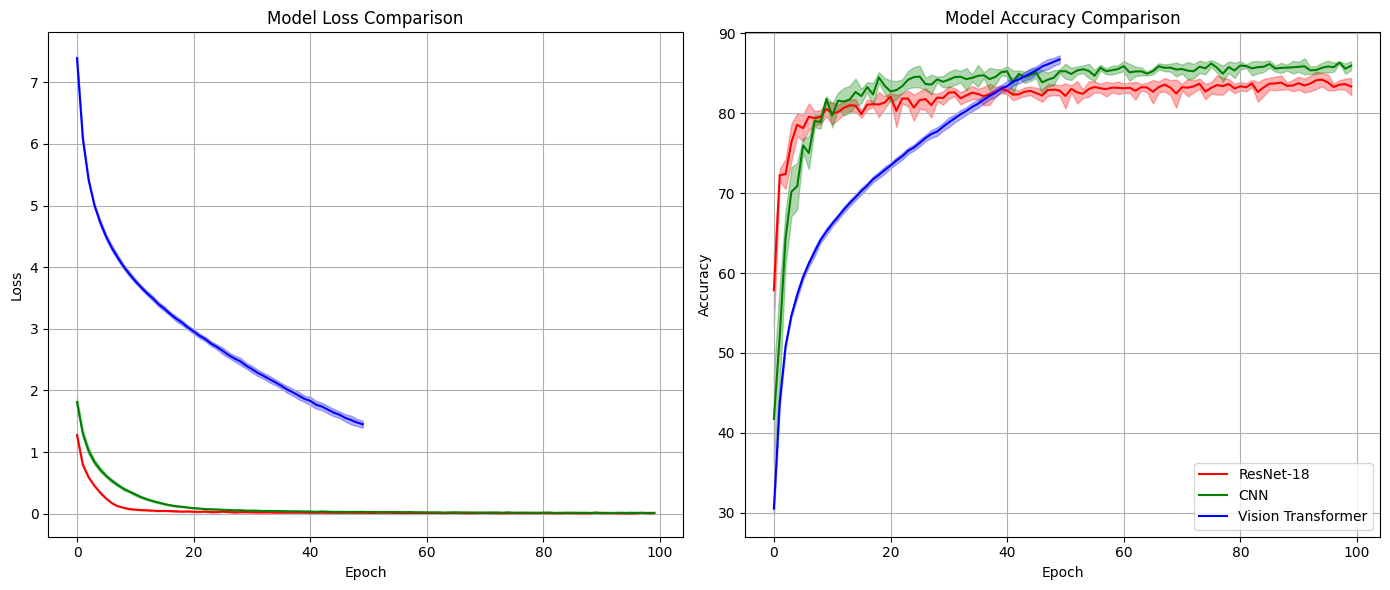

In [73]:
def draw_comparison(loss_data_list, acc_data_list, model_names, trials=5):
    for i, data in enumerate(loss_data_list):
        print(f"Model {model_names[i]} Loss Data Shape:", np.array(data).shape)

    for i, data in enumerate(acc_data_list):
        print(f"Model {model_names[i]} Accuracy Data Shape:", np.array(data).shape)
    epochs = loss_data_list[0].shape[1]
    x = np.arange(epochs)

    # Define colors for each model
    colors = ['red', 'green', 'blue']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Loss
    for i, (loss_data, color) in enumerate(zip(loss_data_list, colors)):
        loss_mean = np.mean(loss_data, axis=0)
        loss_std = np.std(loss_data, axis=0)
        ax1.plot(x, loss_mean, label=f'{model_names[i]} Mean Loss', color=color)
        ax1.fill_between(x, loss_mean - loss_std, loss_mean + loss_std, color=color, alpha=0.3)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Model Loss Comparison')
    ax1.grid(True)

    # Plot Accuracy
    for i, (acc_data, color) in enumerate(zip(acc_data_list, colors)):
        acc_mean = np.mean(acc_data, axis=0)
        acc_std = np.std(acc_data, axis=0)
        ax2.plot(x, acc_mean, label=f'{model_names[i]}', color=color)
        ax2.fill_between(x, acc_mean - acc_std, acc_mean + acc_std, color=color, alpha=0.3)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Model Accuracy Comparison')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    
loss_list = [
    [[1.2597866252588388, 0.7815760701609115, 0.5778538115298786, 0.4410485162045628, 0.3236572523943532, 0.23297433298045453, 0.1632676459015749, 0.11280829256501632, 0.09471242171459304, 0.07225238405667936, 0.05773624057729785, 0.06242856446701212, 0.04877732145025755, 0.048571431820396894, 0.04759925144751327, 0.04660042376218798, 0.044065415127256424, 0.03560534147203516, 0.03271292140722251, 0.032955826858219246, 0.02787869261985365, 0.026310301456115424, 0.04316078854007676, 0.028658495090839366, 0.02118110412786813, 0.027952021647679112, 0.02559201483381912, 0.02759841300945836, 0.023614189288870525, 0.02104521522163815, 0.020886744385192425, 0.017602506683475096, 0.020428877867354353, 0.031003545404199105, 0.01820451276369033, 0.008416311086901945, 0.013520106472070895, 0.026323515783471706, 0.019256077688217115, 0.014758073437533836, 0.010872599735888415, 0.02152853240906157, 0.0202042835099941, 0.014245660205032939, 0.012804943889665146, 0.015115635631021675, 0.013107039229864382, 0.008184726865416892, 0.01415865735554236, 0.021565136850018207, 0.009194243593799202, 0.00394831302674283, 0.009926823679627512, 0.021902700266488398, 0.018421832022324842, 0.00690610359439646, 0.011974438478438052, 0.009639063751831399, 0.0140664055223332, 0.00797069612113605, 0.008911664772731514, 0.012562265690070571, 0.0118025432635047, 0.016172395923514122, 0.010570745262151477, 0.0049994156503356795, 0.0031815667678982574, 0.007169599967201879, 0.018286300942715713, 0.010784800573784566, 0.0036988139115612414, 0.006490769442962846, 0.01033295346270096, 0.013440763643139769, 0.007682756217309652, 0.0031885514984426842, 0.003120482262930657, 0.011658787261375038, 0.01782631667112536, 0.011153981098599755, 0.00407707402615479, 0.0025714777045349143, 0.0033769847343468624, 0.009015034983073279, 0.0141287903263899, 0.008305793728472252, 0.0037169212415979354, 0.0057350816344967845, 0.0040570606610339024, 0.010393309750751317, 0.0065803075652767955, 0.005092243822474438, 0.006389343936845512, 0.005975524357454444, 0.005008302860845399, 0.005009583153715617, 0.008954996585403066, 0.00660160237441796, 0.0037880816149371273, 0.008957989093309757], [1.2907640117045027, 0.8187371435256812, 0.6110622845709134, 0.46975409656096573, 0.359881740884659, 0.2635729487616414, 0.17583914576009058, 0.12896895099181338, 0.0992933845819947, 0.07851922657852546, 0.06760396952993764, 0.05282259082344298, 0.05833050378631003, 0.04167417881968684, 0.04409890454679061, 0.05127521004742041, 0.045761967152238084, 0.03319725853587373, 0.033303504067729, 0.04100948754257668, 0.03198498897641278, 0.030858146354776267, 0.03451330752294963, 0.019434904604525374, 0.022146188645637013, 0.03374377786986732, 0.033978759415653016, 0.02314829213463645, 0.019564140047346162, 0.0256762615095946, 0.01718467296245835, 0.020248985246787914, 0.030365168981268235, 0.015063745923397598, 0.011062698983228408, 0.02253828724236644, 0.02964222653692338, 0.01509857723538127, 0.009346829669781776, 0.01586894084840415, 0.027496375607329603, 0.009407310353661961, 0.02078792098758983, 0.00950548829904221, 0.01983293021166959, 0.011956493779083345, 0.015226735051973505, 0.013984246954339342, 0.009136082094466572, 0.00959128350323139, 0.017621098063456953, 0.016200483880909947, 0.016841293117064927, 0.011057022518345182, 0.007986302193584881, 0.007374134088774173, 0.01218321198312463, 0.015520143457193719, 0.011592501768316612, 0.008938696120269898, 0.01314641962115844, 0.0101793010416529, 0.01191444599750573, 0.008438660411866004, 0.009147922713028717, 0.00935822609475793, 0.00881642861157033, 0.010941402954903461, 0.010513381075155669, 0.00510760632627957, 0.0026232625867954754, 0.01601242658369929, 0.015619927399243918, 0.0041039866088123725, 0.0025472688835484827, 0.0035456873837699625, 0.007514765955092096, 0.020726227990904685, 0.007072683840149217, 0.0038494410938944555, 0.002239438592944305, 0.008563150483941006, 0.015036279344404959, 0.005859972250177067, 0.010149486254259666, 0.0059740043218825395, 0.00365268264010175, 0.006508298271907556, 0.011144917705469168, 0.007916900776251805, 0.003826373905209771, 0.008023291296567753, 0.01230301458153249, 0.009558241225103717, 0.0034691894319615686, 0.0018961789813193826, 0.003163393934808035, 0.001365238827859978, 0.006353251079429155, 0.0176991548805251], [1.3033334104397807, 0.8111392442410746, 0.5963080124542736, 0.46174905813349704, 0.34609226696788314, 0.2501736630837377, 0.17501876000969555, 0.1202613800026167, 0.09043138523618825, 0.07861413196110116, 0.06924923064526373, 0.048543964759610335, 0.05935131588254493, 0.050639954701321904, 0.04587275902190195, 0.04002122037237683, 0.036215653001797944, 0.0379169528371098, 0.03517890578067412, 0.04544653729148828, 0.019642760664166602, 0.038814677471167056, 0.03852786497918133, 0.01774826693830613, 0.02131269427987869, 0.03723238043847104, 0.025177825742904038, 0.015514523060188983, 0.032452127481542956, 0.024491117573707713, 0.02021050742550637, 0.0204313673945062, 0.020680522503027807, 0.02573324823636746, 0.013390658831641528, 0.016890683410742794, 0.022147825869066586, 0.027924808886492798, 0.01361347469525373, 0.010953937798512343, 0.009992641183562925, 0.02500845672576294, 0.01505023596151665, 0.011259195879932096, 0.012713940014316777, 0.014949866855666176, 0.02109070544470676, 0.014822810875272718, 0.010325993627871233, 0.008328715758519054, 0.012943131835408175, 0.01922741509377421, 0.011905356079964645, 0.00908383015608218, 0.015074342246974086, 0.016011976819658748, 0.006500365321664195, 0.006068114870770525, 0.009740766360208365, 0.016985259362040445, 0.008959230483340278, 0.006482935632291152, 0.010266461658382457, 0.007880047304104246, 0.015642589674477327, 0.013830910385575164, 0.008292333521867564, 0.0031878463087283166, 0.0028982653145013695, 0.01466745608797846, 0.01686091686491282, 0.0076880427936579995, 0.0035307111856252398, 0.0036877645829089902, 0.00947312621828693, 0.014929981304892561, 0.005916715267651275, 0.006848102103844032, 0.004983181796542165, 0.011893241241450712, 0.008399554909063361, 0.006363158771072371, 0.004288951041079956, 0.005550933992429501, 0.008427091523468863, 0.013600870451038947, 0.008900868110363596, 0.004370114392023619, 0.00217658179729779, 0.008488691790802704, 0.00786161340276969, 0.0102408472925244, 0.007364148059004889, 0.003071994351406707, 0.0023141444676417077, 0.005106796578787815, 0.013908724624750252, 0.01114491499875482, 0.0058332079163239785, 0.002732451661922649], [1.2456762274614157, 0.7697226704119112, 0.5749243045576845, 0.4460274093924239, 0.333201852421791, 0.23912479354741092, 0.1644098296309241, 0.11730311681834844, 0.09725147058455327, 0.06843303410877911, 0.06430935460223129, 0.06834079734624003, 0.043201612718492606, 0.06036692506190354, 0.04056273732548609, 0.041504783625045, 0.02952856127137003, 0.05578920451742701, 0.0299084288601469, 0.02598444355938869, 0.04752890578956126, 0.02621176440942699, 0.020074413196680643, 0.0334698105087361, 0.02787219583519553, 0.027742428732061456, 0.027022029596608512, 0.026896246169625333, 0.01829595748798553, 0.024197339170003166, 0.025811813538336156, 0.025776249688146964, 0.0174088731758481, 0.01348089123239217, 0.023961153722884425, 0.023960863543375316, 0.00842838036923888, 0.008209522309192916, 0.027145343012929247, 0.022554509365520538, 0.01257867396402079, 0.012913686073345754, 0.02026414485836473, 0.011097088115462384, 0.014499251427474437, 0.013495748173523569, 0.01142934059835141, 0.020248362426303873, 0.01910319901364387, 0.008331737322334836, 0.007027801551420287, 0.014670318191320213, 0.01513414469202787, 0.006967703483732099, 0.009857283732664144, 0.01780595921417743, 0.013026480249072702, 0.006001007507641011, 0.010037734463718681, 0.009858112384177619, 0.015024269864070244, 0.012865777693063277, 0.006717220256741537, 0.006670764458127283, 0.01779181303398497, 0.013827381696172758, 0.005093777391955144, 0.002276753762650163, 0.0036724929896662594, 0.016676559228631704, 0.01863851450672284, 0.0063983578108895095, 0.004298512113113968, 0.001866540232374671, 0.007323609771327947, 0.019800322726300095, 0.012383902743029165, 0.0037591926288405957, 0.0036533981475424396, 0.010531815097589589, 0.009152062322749416, 0.009546058264681133, 0.005055845500336931, 0.005102683271296485, 0.011481209184010008, 0.006610785842630562, 0.01038169320540714, 0.007328594968358853, 0.001499132565880771, 0.0006108225769351, 0.0004961140281162565, 0.01890981613590479, 0.010973308512334936, 0.005410882146045184, 0.007855436560930684, 0.005140777666337164, 0.005864066773162417, 0.00442780321719066, 0.004582418288041612, 0.010155861363706243], [1.2692901050320828, 0.7800222715249838, 0.577630930815261, 0.4387013420891076, 0.3262404319577324, 0.23664981698075804, 0.16656344319684818, 0.1256436579072247, 0.09220479257678547, 0.07455935497610523, 0.06365651103516166, 0.059931252635241794, 0.06219316689898602, 0.04214860038599743, 0.03577348689724224, 0.04596465957401612, 0.053901681474174935, 0.02959792090530772, 0.0325812593998072, 0.039744824328022406, 0.035395538932405796, 0.02535893868791838, 0.03185268202365135, 0.026888904023391846, 0.03151436069792065, 0.036997987243448036, 0.020433309174458177, 0.010772196069890157, 0.0275105391483986, 0.02916870144976544, 0.025903370843593256, 0.01595242256970002, 0.016437920462228535, 0.02523513781084395, 0.021414141635597943, 0.0191844388981686, 0.014793360692961438, 0.013235592927079657, 0.021055969347717602, 0.024057503029709302, 0.015177547752027051, 0.008364791475139155, 0.017445154902142154, 0.019854088449261537, 0.01599536365781057, 0.01182976439457607, 0.01526379568175749, 0.010177187385299196, 0.014289541124927287, 0.015700584415498132, 0.011486377427298664, 0.008332375587468532, 0.010177326903553136, 0.02003366902850705, 0.01315984630905361, 0.008725910381008216, 0.009705334511325553, 0.011566353682479739, 0.015795843395712852, 0.007834312979863903, 0.0057344501463713286, 0.01888267185696428, 0.008921724238543408, 0.0027466755082262936, 0.002720797953000651, 0.019972583015196246, 0.01940698720110854, 0.006921408152614628, 0.002932545049955075, 0.005722976756960605, 0.012862423442719375, 0.0115965634640031, 0.00431308084992629, 0.004723527821363369, 0.014294126054856736, 0.01275500495214768, 0.00363400712885545, 0.003566035537545985, 0.0015171720756791964, 0.0019701005417365708, 0.024199286358153518, 0.012955583365431938, 0.004186204313744081, 0.0007242724124848545, 0.0006645971853212571, 0.0004338843069409034, 0.00019632361661566254, 7.935590168761238e-05, 0.0013608666755555515, 0.05119438721934488, 0.004301780060776279, 0.0013081930166674992, 0.0006093856326640325, 0.00031871943183461507, 0.00013276839386547183, 8.870089941294468e-05, 0.0018410479562049433, 0.04150762006037157, 0.00498379847862272, 0.00116308232630569]],
    [[1.804732616336201, 1.3061241284726908, 1.0155662875205944, 0.8438166665573852, 0.7223711739332912, 0.6202041138284884, 0.5321137772771878, 0.46896745964361075, 0.4090248798124326, 0.3528590689832791, 0.30781614154386827, 0.26363265723846974, 0.23419247193934437, 0.2064783418902193, 0.18066511922084486, 0.153163228053064, 0.1363651534667411, 0.11520411917410148, 0.11132073645203258, 0.102517316820094, 0.08834299154151172, 0.08692233284828238, 0.08096988503032694, 0.0631892029240656, 0.06600645518662354, 0.06363609148979413, 0.06208933288002381, 0.05362312337785317, 0.056635710359446874, 0.04702379322162987, 0.048765946907875016, 0.04935427889962065, 0.04239163817908502, 0.04583457491089837, 0.04078759321870026, 0.04005614913309725, 0.03808796716543039, 0.038774771050523266, 0.03611175351521036, 0.038185794422694576, 0.038733149255040476, 0.032248734960335486, 0.030493983811439987, 0.028527315391265542, 0.02305368189646947, 0.034968921355819464, 0.027336414769692077, 0.026378988426330442, 0.02875283735306984, 0.03109487356774631, 0.028322832706726912, 0.023120046145719338, 0.022858378895215865, 0.034008891023427676, 0.02330431596453364, 0.022006186960151972, 0.019313610846264335, 0.028420859650439455, 0.021488962182617068, 0.023771673976401866, 0.018714392900291366, 0.027586650717718982, 0.02555187856414007, 0.0163291162421061, 0.02199284882082369, 0.0163089281528655, 0.019305704524741507, 0.02271964094921342, 0.016666134182126084, 0.015043727171227723, 0.01479346975970555, 0.023360578316121032, 0.018197135205347888, 0.02096404502243475, 0.014989112112540495, 0.020749759294590397, 0.01578692265921475, 0.014623114585182761, 0.017987363297662796, 0.011555544469426362, 0.014589957943896186, 0.017037897365815926, 0.012472378749090927, 0.010642314160129888, 0.019538178735527212, 0.013980695591693128, 0.015927288666472694, 0.009749850347338399, 0.01719075558898571, 0.009682118247933823, 0.016122508747089384, 0.011742944777410457, 0.010614167039290105, 0.01953916270029443, 0.008474637398319265, 0.014942688219654169, 0.01514213597951044, 0.013774310536032187, 0.008806032277367868, 0.012655057271505659], [1.8934052874105045, 1.3587117145617549, 1.0751297045439576, 0.8780288212596418, 0.7505675641873393, 0.6420915553364129, 0.5707543180963863, 0.4920145282730127, 0.42914323351634576, 0.3774079870872985, 0.3442719534467965, 0.29377120116743416, 0.24701956733347127, 0.22307608900264428, 0.19119086816383246, 0.16905969536056914, 0.14835940532909986, 0.13415601651984663, 0.12083471632494142, 0.1066763402816777, 0.09882814400255109, 0.0838607010868982, 0.08093478864790818, 0.08075917044434304, 0.06805391717380799, 0.06488790444154947, 0.06148401928393129, 0.05953157826671942, 0.055741275883854004, 0.04524326178181274, 0.050031389634961045, 0.04922037528040774, 0.04979809221049872, 0.03862627336759858, 0.04777145856573357, 0.044125463314965876, 0.03670142359582309, 0.035340167073136454, 0.03428266084068247, 0.03279518492772027, 0.038246651540213554, 0.029799973214463222, 0.03755561336486291, 0.033328760027946436, 0.03037735110426994, 0.032418090926268295, 0.03104189704038417, 0.031803230176208924, 0.028260838904519588, 0.025663359713582204, 0.019694050800036854, 0.027066439071202653, 0.02365900015103454, 0.024489134453717223, 0.028396643867445424, 0.023342546410880946, 0.021498513462354082, 0.029824389605278955, 0.02179500622567055, 0.02159520544683182, 0.02280375375214582, 0.018807382631378666, 0.020209896366875143, 0.0170291603572898, 0.02288296077069053, 0.027076446168158522, 0.017458422696954325, 0.022333192357731336, 0.017993302767027576, 0.01912744045844643, 0.015786155909921443, 0.017925012729811046, 0.02229798953781595, 0.013208968380481724, 0.029146884675292053, 0.014556733481275879, 0.01794575536407643, 0.013804797870145815, 0.01792798965066678, 0.019262381027292344, 0.01567769103088193, 0.016775710774520423, 0.01288451223256717, 0.012102727900000377, 0.015981605189653712, 0.019877580730315765, 0.015186082671981115, 0.01687536501984827, 0.012925917940180942, 0.013757023586828572, 0.013633969631903132, 0.016047541778768968, 0.0100867288829017, 0.013031250161173132, 0.017093926007903017, 0.013542046690211612, 0.01283457918781988, 0.010701640099930014, 0.013064395521093237, 0.018086985423235075], [1.8827085384545617, 1.3676533942786269, 1.0774775494020967, 0.8759224868049256, 0.7434116181093283, 0.6359671766575152, 0.5500822923244378, 0.482226697400736, 0.422361648454072, 0.3758186099533075, 0.3177989975046426, 0.2819161131359137, 0.24765537019830924, 0.21269336716530804, 0.19250786966218736, 0.16043338358116607, 0.1418640211034126, 0.12319576451049065, 0.11051348763437698, 0.10135961650385739, 0.09625331824199079, 0.0873501699048871, 0.06749226051433303, 0.07529749257710223, 0.06954450318560051, 0.0650499053715993, 0.06256070220842957, 0.052176948802652785, 0.053100960542851044, 0.052182149646555286, 0.05132999950156997, 0.04713309152623097, 0.044461189309498085, 0.043159715473479306, 0.042284385140497274, 0.042692526708079576, 0.03705003158637165, 0.040913408668637394, 0.03687777710794367, 0.03798718536837985, 0.03981843716933574, 0.03237380514839313, 0.034553337828789915, 0.029593026413903618, 0.031809236872167634, 0.024259417443056427, 0.029090240025504553, 0.027681279686200003, 0.024233696921825254, 0.02455353398073521, 0.034518537909657615, 0.02253305685974973, 0.02622214722948836, 0.020502870932917673, 0.03265919402437344, 0.02530717562998276, 0.03409582841667174, 0.021700709113813905, 0.018110060714779497, 0.02327824097394329, 0.021501811113241634, 0.021332613451225228, 0.020919868513275444, 0.013995293087402052, 0.019738251172837774, 0.02139550585149283, 0.019835530609160372, 0.020826476091960346, 0.021638761832254765, 0.021413141845820508, 0.020289661252581793, 0.011714700977299857, 0.022303838178868027, 0.016375506568602722, 0.02027286212571849, 0.015400028233697188, 0.01365458067594793, 0.020928764830328968, 0.016211332015337247, 0.014324810391342955, 0.01610482530921758, 0.02046412927198855, 0.01587419473464205, 0.01563036627447991, 0.013734232632481153, 0.014930866377351533, 0.014477102092270867, 0.011577420511335562, 0.010694882829954096, 0.012808471569516809, 0.018495401911550812, 0.012340660752368178, 0.015321549656831145, 0.01226842317692135, 0.012173123925158768, 0.014456467233877323, 0.015628172902409143, 0.015095460591652727, 0.013033087126233859, 0.013446242196684548], [1.7568120689818654, 1.2610968456100733, 0.9767667765434558, 0.8076093794819647, 0.6906178774544225, 0.5918931573534164, 0.5168571878736392, 0.44982770685189827, 0.3863701065793967, 0.34891342269345976, 0.30770419133356963, 0.26097304604876154, 0.2262770033682497, 0.1964153125644111, 0.17418621904172074, 0.1559625944128623, 0.1342604776350454, 0.12099140875350933, 0.11073894765430366, 0.09744121287815487, 0.08214382754085353, 0.08491444835117973, 0.07356659162004059, 0.06759622504119389, 0.06551392359165148, 0.06039819287987182, 0.058210518260221604, 0.04760200038445167, 0.056950421884846385, 0.05023312231246085, 0.04749774092997308, 0.047732894761136735, 0.04007025453754472, 0.04715919063111154, 0.041107617454758036, 0.04452134389839412, 0.043619808266884066, 0.03721768481113141, 0.04473225259223578, 0.03130954267872206, 0.028215535854275067, 0.025616246383046187, 0.04062031269647752, 0.035053661004781494, 0.029128814622694357, 0.028877145680766284, 0.027732904834937625, 0.026244875029032194, 0.03212293379098778, 0.03317216376364142, 0.021735242387800946, 0.03343197962673851, 0.023443341110738147, 0.0242832409646933, 0.017818882721135937, 0.030581075278130886, 0.01943251656412728, 0.02722474140776753, 0.021464570770373035, 0.021880980598874732, 0.023796236380832805, 0.019032088442415555, 0.019814013829154906, 0.02266702054187651, 0.018885849949618512, 0.01915082199330339, 0.020177656280218264, 0.019103341113537745, 0.017662898658612723, 0.017728272855792124, 0.015685341344538094, 0.02409488120283292, 0.021267326410266404, 0.010871037156298792, 0.021087063574052704, 0.014752182794307855, 0.02021437678755877, 0.016547341529134334, 0.012366952373304811, 0.013365023218720337, 0.017103785017537645, 0.021123748782869392, 0.010287819611491727, 0.016234785655898868, 0.013568608181143785, 0.015589668907171852, 0.007489704265700506, 0.020057808830953813, 0.013105796928188918, 0.016432291479628686, 0.014986602506546761, 0.012692628679523216, 0.013652584107743091, 0.013386642685169897, 0.017774840992873166, 0.010408658534753324, 0.009378793503992856, 0.015827662821810955, 0.017975990877233106, 0.011601410506272442], [1.715405396379221, 1.200147349423113, 0.9387489528701709, 0.7700763446644853, 0.6514147474362065, 0.5717329853258956, 0.4866388929537691, 0.4284191733827225, 0.3648581890918957, 0.33181481836988524, 0.2773391909111803, 0.24117213128188167, 0.20851328171575412, 0.1801696878890641, 0.1579254082145211, 0.1393835286910351, 0.11883840969980905, 0.10777938207641197, 0.10490807411246025, 0.0891377755646079, 0.07808320047839666, 0.07549031080600743, 0.064018671615079, 0.06450884346627056, 0.07157156221753064, 0.058208119187030956, 0.05401241790411024, 0.05796637852786305, 0.05292746474216588, 0.049895501871126145, 0.047359885575365836, 0.04478887131901833, 0.03957516481295026, 0.044405691495638326, 0.03979257095144681, 0.03738796096830703, 0.03876882270104981, 0.03866808228685666, 0.036377004573877436, 0.03317656145042802, 0.0348312181326525, 0.02487010098820829, 0.03587693054978096, 0.03376687967092745, 0.028133982335668824, 0.024995117362167616, 0.02525258310285721, 0.02864379690422233, 0.029170605313842194, 0.03057694789340211, 0.02971015124234554, 0.024887989632086178, 0.02368709873188638, 0.024220958621926997, 0.020265176099398787, 0.02611138742536488, 0.022305111753236958, 0.025191257640245383, 0.02609140637932128, 0.024743498906365985, 0.020514346773739155, 0.013499605789024755, 0.023192225226901095, 0.01677039127002391, 0.018538108073106054, 0.021967196566718125, 0.02409374693601735, 0.015561503373945991, 0.015275162987665517, 0.02234268795985317, 0.021425212518981145, 0.017707683822873178, 0.016542569597609885, 0.01645647424306016, 0.022598441884797715, 0.010328667729051774, 0.020765750331075816, 0.01602711459057749, 0.013859928475008323, 0.017814362351127086, 0.01641385598167182, 0.016639989800090155, 0.011892793979897917, 0.014763940133096, 0.01739455641296799, 0.013892082285701835, 0.017354130197772773, 0.01683309613749349, 0.010708355985787439, 0.018856980765261464, 0.00876248743203503, 0.011470065439280239, 0.01249871155187211, 0.018720361232345557, 0.00731701844160097, 0.01930737074609916, 0.012283210156297332, 0.01143464047499482, 0.010793403647812302, 0.013095566712911877]],
    [[7.349329643737013, 6.040249907551482, 5.419871328356929, 5.035770037494148, 4.795717018100019, 4.53271712834081, 4.361794854124514, 4.20591686061396, 4.038664959680539, 3.904166247231511, 3.8083360690278365, 3.69099976070011, 3.5971041743557293, 3.5048574675767186, 3.403141270144679, 3.321494793834778, 3.249016472135489, 3.175815982083543, 3.10857345225712, 3.0371692097796417, 2.9598726074154764, 2.897807747506486, 2.8515189529988714, 2.787657224427397, 2.7230056578549333, 2.6530915842459986, 2.595220899239135, 2.5452008135973836, 2.5123157943494783, 2.4206346648569688, 2.3958415306223846, 2.3280180870724942, 2.246764940718492, 2.2293836648186174, 2.1738346906991812, 2.1172126343075077, 2.0544576972437363, 2.020837565961356, 1.967414891043791, 1.9041171480958072, 1.8949992449614947, 1.8238029213140186, 1.7914315606363285, 1.739136724807203, 1.688179674763649, 1.6678522208961435, 1.6049910543349604, 1.569734089183636, 1.5308381846299568, 1.4937477048498373], [7.3686791852640265, 6.0044365957522166, 5.353430871575023, 4.967267000827546, 4.682396051030571, 4.454736037757069, 4.27030228025997, 4.121692145023102, 3.9680441660812487, 3.835639811838016, 3.72131819904041, 3.630660916384036, 3.5302090457262705, 3.4515000332277803, 3.3453990195315484, 3.269604623127288, 3.187552689077755, 3.114785110893341, 3.0554354081329067, 2.989351774271304, 2.9020978774125585, 2.8369509950518226, 2.7884095622042118, 2.7157680535564026, 2.653053354483824, 2.5735531664504028, 2.5211141248004507, 2.4681001932095414, 2.4045482374513494, 2.3514210060476874, 2.298077009451656, 2.2282260127437, 2.2039718671252553, 2.1342031038321627, 2.099058076025198, 2.0301080541060377, 1.9621103390956078, 1.91812172155982, 1.8680759516720193, 1.8300689075130243, 1.7671155617259944, 1.7064644804539773, 1.6777400699334022, 1.6249190322316873, 1.6039813392030926, 1.5685285418606794, 1.5043934715774874, 1.4724117504855314, 1.4221723644068827, 1.416823155713824], [7.37927668277448, 6.081957480206657, 5.432812102115192, 5.02267556735121, 4.753651416339813, 4.533054348188467, 4.342220277260668, 4.193271599067286, 4.036953483717129, 3.9378991782093964, 3.800229700419088, 3.686226675209527, 3.603370171766312, 3.528535077175774, 3.422827112598541, 3.355623065758818, 3.2645691118110864, 3.1881963279300605, 3.1319415815912497, 3.0435749224770947, 2.981417179202881, 2.912031964181711, 2.864799406105718, 2.785075359403516, 2.735405324985044, 2.6833029811660323, 2.606916320638154, 2.5653678214968965, 2.5198699903373902, 2.4364014869204724, 2.3962746062122595, 2.330418798346489, 2.279927075861361, 2.222025846520933, 2.1728458181261634, 2.115096117170474, 2.0601874115272834, 2.023350044466055, 1.969577680332973, 1.9180888333997597, 1.8862446992161175, 1.8179819271825373, 1.7990653331573017, 1.7627561822200355, 1.6892825141073036, 1.6296348814099741, 1.6128652824666172, 1.5830735797984912, 1.54549675372938, 1.5115645254215302], [7.365990836018572, 6.1105320461261, 5.398906371083123, 4.961798630392971, 4.667878734798858, 4.431673130478722, 4.239516503132951, 4.096588594273637, 3.957853387719907, 3.842231414855098, 3.742009641549077, 3.6405036909321247, 3.543688051521588, 3.4446306738038412, 3.3672702838056767, 3.295728045816239, 3.2190164505673673, 3.1196081533599584, 3.0537186550160946, 2.9767868465508895, 2.9251826380769286, 2.8499786922345147, 2.791011171123852, 2.70619259907986, 2.6633782735267006, 2.5839037087778696, 2.5144389217463545, 2.457208214190821, 2.3928743219984985, 2.344272865559727, 2.2635762829083603, 2.21617019276459, 2.159986730581655, 2.1001890416676625, 2.058672270930994, 2.0125208254725027, 1.9389522287268608, 1.8918258629191798, 1.8192383650773631, 1.7809826502213464, 1.7317976496947078, 1.6790329742307861, 1.6527861495749256, 1.6105655874259555, 1.540765544715019, 1.5237590250449058, 1.4668930467610923, 1.4011331984933955, 1.4034226255747266, 1.35822211822477], [7.484382637773459, 6.169754946574616, 5.436020501695883, 5.004862456847303, 4.709047388535338, 4.505900189708978, 4.325674264956587, 4.14627310214713, 4.038413952143428, 3.918384250646201, 3.7956977631337345, 3.716514954361291, 3.61442393140671, 3.5378140186349425, 3.4469789744566044, 3.3790173356335003, 3.2773675857641447, 3.22288949839985, 3.1498209497037406, 3.0668363793970297, 3.0169660277640857, 2.9362732065847506, 2.8670302508547665, 2.7980345898923784, 2.748383511321994, 2.7098855311973407, 2.6257565954146673, 2.5537800488475795, 2.5290235403818064, 2.4561259835101543, 2.3698755017579933, 2.316945618952806, 2.2876670266778323, 2.225064194383332, 2.1557238217169483, 2.110440154949697, 2.066641955329968, 1.998171662036984, 1.958919942474213, 1.8835960379280983, 1.8700548134767971, 1.809579934817724, 1.7690214139346878, 1.7106347796016228, 1.6810747703995568, 1.6378218436155456, 1.5847769429722725, 1.5707141680363268, 1.4934496095243353, 1.4755328569216088]]
]
acc_list = [
    [[57.77, 72.33, 72.32, 72.89, 79.8, 77.65, 81.55, 79.52, 78.18, 79.74, 81.31, 79.86, 81.09, 79.67, 81.38, 79.22, 80.21, 81.14, 78.11, 80.62, 81.73, 81.04, 81.26, 82.1, 82.33, 82.1, 81.65, 79.91, 81.22, 81.71, 82.61, 82.27, 81.87, 81.41, 83.2, 81.96, 82.31, 80.65, 82.08, 82.87, 82.56, 81.33, 82.53, 82.51, 83.16, 81.95, 82.23, 82.13, 81.91, 81.93, 83.55, 83.32, 80.16, 81.68, 83.48, 81.95, 83.29, 82.45, 82.47, 83.72, 82.43, 83.3, 80.93, 82.73, 83.24, 83.81, 82.93, 82.02, 81.38, 83.19, 82.83, 82.77, 82.02, 82.53, 81.65, 83.42, 83.05, 81.44, 82.82, 83.95, 83.81, 82.89, 83.06, 81.32, 82.17, 83.14, 82.97, 82.78, 83.24, 82.24, 82.67, 83.39, 82.31, 82.89, 83.13, 82.7, 83.09, 83.18, 83.39, 82.07], [63.25, 72.33, 71.42, 76.2, 79.65, 78.52, 79.57, 77.8, 80.19, 81.21, 78.95, 81.61, 82.06, 81.72, 80.17, 79.89, 80.66, 80.75, 81.9, 82.39, 82.37, 79.68, 82.27, 82.96, 77.72, 82.0, 83.33, 83.72, 82.65, 83.37, 83.09, 82.82, 81.88, 83.57, 82.92, 82.29, 82.61, 83.36, 83.88, 83.08, 83.22, 83.03, 82.88, 83.29, 83.22, 82.7, 81.09, 83.64, 83.33, 82.34, 82.17, 83.2, 83.88, 83.29, 84.08, 83.85, 82.3, 81.81, 84.21, 83.78, 83.04, 83.42, 83.06, 83.58, 83.99, 83.33, 83.76, 83.83, 83.85, 84.34, 83.68, 81.32, 83.21, 84.13, 84.48, 83.85, 81.43, 83.24, 83.69, 83.62, 84.2, 82.79, 83.65, 82.02, 83.07, 84.01, 83.57, 83.1, 83.28, 83.52, 84.26, 83.27, 83.29, 84.53, 84.26, 84.15, 83.3, 84.48, 82.53, 82.57], [62.56, 70.85, 75.97, 79.33, 76.58, 79.8, 80.12, 80.32, 80.63, 81.6, 80.62, 80.53, 80.41, 81.7, 81.07, 80.42, 82.11, 81.26, 82.18, 81.4, 82.9, 76.75, 82.74, 81.32, 82.03, 82.3, 82.55, 81.78, 81.85, 80.86, 82.89, 82.22, 80.58, 81.77, 83.37, 81.77, 79.99, 83.49, 82.6, 83.91, 83.24, 81.78, 82.75, 83.22, 82.54, 81.55, 82.65, 83.75, 83.76, 82.9, 79.14, 82.55, 84.09, 82.53, 82.6, 83.61, 84.0, 84.56, 83.19, 82.39, 83.97, 84.22, 83.76, 83.44, 82.64, 83.47, 84.05, 84.53, 83.77, 82.07, 83.49, 84.3, 84.1, 83.64, 82.55, 83.03, 84.14, 84.18, 83.25, 82.56, 83.03, 84.19, 83.78, 83.11, 83.12, 82.89, 83.7, 84.0, 83.65, 83.27, 83.2, 83.27, 83.86, 84.65, 84.44, 83.55, 82.76, 83.05, 84.22, 84.23], [53.5, 72.39, 71.22, 78.41, 79.74, 75.24, 76.55, 80.1, 79.04, 81.08, 77.85, 79.95, 80.11, 80.96, 80.06, 80.3, 80.85, 81.7, 82.39, 81.99, 81.7, 82.81, 81.09, 80.22, 80.73, 82.37, 79.31, 80.17, 82.01, 82.18, 81.07, 82.38, 83.0, 82.06, 81.01, 82.48, 83.45, 80.92, 82.36, 82.69, 82.12, 82.35, 81.66, 81.77, 81.88, 83.31, 81.77, 81.96, 83.4, 83.55, 83.0, 82.57, 82.66, 82.6, 81.35, 83.59, 83.1, 82.98, 83.22, 82.09, 82.62, 82.81, 82.36, 82.88, 82.52, 83.09, 83.53, 83.96, 83.55, 79.27, 83.63, 83.59, 83.49, 83.96, 82.05, 81.91, 84.25, 83.84, 84.07, 82.91, 82.98, 83.06, 83.75, 82.09, 82.6, 83.55, 83.11, 84.04, 84.11, 84.13, 83.77, 82.38, 83.88, 82.9, 83.66, 83.39, 84.04, 83.24, 83.6, 82.99], [52.14, 73.37, 71.01, 74.96, 77.08, 79.46, 80.14, 79.19, 79.7, 79.13, 81.22, 78.8, 79.79, 80.95, 82.17, 79.62, 81.54, 80.94, 80.92, 80.42, 81.85, 81.23, 81.89, 82.64, 80.72, 79.47, 82.06, 79.56, 82.12, 81.43, 83.31, 83.54, 82.1, 82.37, 82.46, 83.58, 82.43, 83.49, 82.59, 82.58, 83.21, 83.2, 82.03, 82.73, 83.21, 83.15, 83.35, 83.1, 82.45, 83.55, 82.99, 83.67, 82.32, 82.16, 83.69, 83.5, 82.97, 83.37, 82.97, 83.98, 83.61, 82.29, 84.03, 83.71, 83.79, 79.8, 82.15, 83.6, 83.53, 83.51, 82.71, 84.08, 84.04, 84.31, 82.89, 83.77, 84.84, 84.28, 84.58, 82.48, 82.9, 83.39, 84.44, 84.82, 85.28, 84.97, 85.35, 85.33, 82.93, 84.26, 84.99, 85.06, 85.31, 85.72, 85.59, 85.61, 83.28, 84.01, 84.49, 84.95]],
    [[43.38, 52.73, 63.41, 64.45, 67.23, 76.85, 73.21, 80.04, 78.97, 81.25, 79.34, 82.52, 83.84, 83.05, 79.64, 83.23, 83.64, 82.7, 84.51, 82.67, 82.39, 83.09, 83.59, 84.98, 84.14, 84.91, 84.13, 85.61, 84.18, 82.95, 83.43, 85.26, 83.67, 84.58, 84.82, 85.99, 84.75, 85.6, 82.67, 85.48, 84.09, 85.3, 84.66, 85.34, 85.45, 85.56, 82.63, 84.4, 85.04, 84.96, 87.03, 85.44, 85.16, 86.15, 86.51, 85.72, 86.02, 85.76, 85.95, 85.73, 85.61, 84.56, 85.78, 84.77, 85.21, 84.74, 85.8, 85.98, 86.1, 85.78, 85.9, 85.96, 84.19, 85.26, 85.92, 86.13, 84.9, 84.55, 86.01, 85.32, 85.33, 86.21, 85.86, 85.59, 86.01, 85.95, 86.01, 85.89, 86.14, 86.54, 85.83, 86.77, 84.51, 85.97, 86.16, 85.43, 84.98, 86.27, 86.56, 86.31], [39.33, 44.05, 64.88, 72.83, 68.28, 75.97, 72.88, 78.72, 79.03, 82.07, 77.87, 79.77, 80.88, 82.99, 83.26, 81.83, 83.31, 83.27, 84.61, 84.27, 84.72, 84.0, 84.03, 83.45, 85.18, 84.58, 84.8, 81.95, 83.6, 84.15, 85.37, 84.45, 85.51, 83.41, 84.33, 83.5, 85.21, 85.11, 85.09, 84.81, 85.66, 84.73, 84.33, 84.51, 83.51, 85.27, 84.26, 83.55, 85.18, 85.19, 84.87, 85.53, 85.61, 85.08, 84.41, 84.64, 85.94, 85.06, 85.71, 84.79, 85.39, 85.7, 86.09, 84.92, 85.07, 85.7, 86.34, 85.92, 86.35, 86.27, 86.12, 83.23, 86.02, 86.89, 84.59, 86.19, 86.36, 83.22, 84.8, 85.19, 85.89, 85.81, 85.44, 84.36, 85.71, 86.57, 85.2, 85.08, 85.25, 85.04, 85.93, 86.92, 85.83, 85.29, 86.07, 85.89, 86.3, 86.59, 85.74, 85.86], [31.69, 48.76, 58.42, 69.55, 70.82, 76.5, 75.09, 78.99, 77.38, 82.09, 78.72, 82.55, 78.67, 80.48, 82.12, 81.7, 83.58, 82.79, 83.94, 83.98, 83.59, 81.4, 84.5, 82.76, 85.28, 82.15, 82.98, 83.83, 84.58, 84.67, 84.57, 82.82, 83.83, 82.07, 84.04, 82.67, 84.84, 81.79, 84.88, 85.23, 85.09, 84.35, 84.88, 83.26, 84.73, 84.84, 85.01, 85.38, 82.73, 85.11, 84.5, 84.43, 84.69, 85.48, 84.2, 83.7, 85.24, 84.74, 84.45, 85.39, 85.38, 83.31, 84.99, 84.9, 85.19, 84.94, 85.82, 85.01, 85.62, 83.84, 84.88, 85.59, 84.69, 84.94, 85.0, 85.7, 85.08, 85.56, 85.18, 85.9, 85.5, 85.75, 84.03, 86.34, 86.6, 85.63, 86.02, 85.96, 85.34, 85.74, 84.65, 84.49, 85.45, 84.53, 86.1, 84.79, 85.15, 86.28, 84.68, 84.93], [47.04, 51.65, 68.03, 71.6, 75.03, 74.26, 78.66, 79.61, 79.98, 81.55, 82.21, 81.62, 82.35, 83.12, 84.32, 80.9, 83.81, 79.6, 85.65, 84.35, 80.55, 81.81, 82.6, 85.81, 85.8, 86.37, 83.72, 82.75, 84.43, 84.67, 84.93, 85.68, 84.99, 85.64, 85.05, 86.06, 84.12, 83.71, 85.18, 85.6, 85.88, 83.76, 85.57, 84.45, 85.43, 85.77, 85.75, 82.91, 84.16, 85.38, 85.42, 83.66, 86.18, 85.95, 85.94, 85.25, 86.07, 85.52, 85.77, 85.54, 87.06, 85.82, 84.48, 85.89, 84.64, 85.73, 86.21, 86.18, 84.91, 86.06, 85.98, 86.36, 86.63, 86.61, 86.72, 86.98, 86.39, 86.11, 86.7, 86.66, 86.63, 86.11, 86.55, 86.32, 86.17, 86.81, 85.15, 86.63, 86.06, 84.75, 86.39, 86.33, 85.51, 85.78, 85.6, 86.94, 86.23, 86.3, 85.12, 86.47], [47.25, 63.22, 66.96, 72.46, 73.01, 76.35, 75.3, 77.78, 79.19, 81.96, 80.51, 81.44, 81.62, 78.99, 83.99, 83.15, 82.07, 83.5, 83.78, 81.96, 82.44, 84.2, 82.22, 83.98, 82.26, 84.99, 82.73, 83.85, 84.44, 83.32, 82.74, 84.46, 84.91, 85.72, 83.95, 85.26, 84.9, 85.22, 85.02, 84.63, 85.56, 81.01, 85.23, 85.03, 84.77, 83.98, 81.71, 84.84, 85.15, 85.64, 84.54, 85.56, 85.18, 84.94, 85.52, 84.28, 85.3, 85.21, 85.13, 86.23, 86.09, 86.22, 84.88, 85.81, 84.75, 85.22, 85.27, 85.4, 85.62, 85.47, 84.86, 85.53, 84.84, 85.45, 85.97, 86.19, 85.83, 85.38, 86.28, 83.74, 86.57, 85.7, 86.27, 86.29, 84.66, 85.9, 85.64, 84.89, 85.81, 86.77, 86.31, 84.94, 85.56, 85.59, 84.55, 86.3, 86.2, 86.39, 85.85, 86.26]],
    [[0.30695, 0.44205, 0.506225, 0.54385, 0.565625, 0.591175, 0.6065, 0.621425, 0.638925, 0.6516, 0.65815, 0.6683, 0.6763, 0.6868, 0.69565, 0.702475, 0.707525, 0.717275, 0.722875, 0.72905, 0.733175, 0.74035, 0.74315, 0.7489, 0.755925, 0.762775, 0.76635, 0.7716, 0.775525, 0.780625, 0.78275, 0.7886, 0.799225, 0.800175, 0.805075, 0.807375, 0.8144, 0.817575, 0.820175, 0.82975, 0.8273, 0.834725, 0.838475, 0.84235, 0.845275, 0.848775, 0.853775, 0.856625, 0.859925, 0.864825], [0.309025, 0.448825, 0.51315, 0.550125, 0.57805, 0.597575, 0.6182, 0.631325, 0.646775, 0.656375, 0.66695, 0.6748, 0.684625, 0.692225, 0.6982, 0.707225, 0.71545, 0.720725, 0.7259, 0.732175, 0.738175, 0.74615, 0.751075, 0.754975, 0.76275, 0.767525, 0.7714, 0.778175, 0.78275, 0.787975, 0.7942, 0.79935, 0.8029, 0.807275, 0.809775, 0.816875, 0.8221, 0.825075, 0.829475, 0.8334, 0.83975, 0.8436, 0.845225, 0.85225, 0.853825, 0.856875, 0.86285, 0.864775, 0.869425, 0.869925], [0.30695, 0.439525, 0.5077, 0.546025, 0.5695, 0.59195, 0.6098, 0.61955, 0.6388, 0.6466, 0.659425, 0.668875, 0.676975, 0.685625, 0.692425, 0.701075, 0.7075, 0.714425, 0.7189, 0.7256, 0.734325, 0.7378, 0.7425, 0.751975, 0.75475, 0.76, 0.768, 0.76965, 0.772675, 0.781825, 0.7831, 0.791075, 0.794325, 0.800675, 0.8028, 0.80865, 0.8125, 0.81705, 0.821725, 0.825625, 0.827675, 0.83625, 0.837725, 0.839725, 0.8444, 0.851275, 0.85465, 0.8567, 0.859275, 0.8615], [0.30975, 0.433625, 0.509375, 0.5482, 0.57785, 0.601325, 0.61525, 0.632825, 0.64385, 0.657275, 0.66445, 0.673875, 0.6833, 0.691175, 0.6992, 0.70685, 0.7111, 0.722125, 0.7284, 0.734925, 0.738525, 0.7441, 0.751125, 0.759475, 0.759725, 0.768075, 0.77505, 0.7817, 0.783875, 0.789225, 0.79725, 0.799725, 0.80575, 0.8097, 0.817225, 0.819175, 0.82405, 0.829075, 0.83475, 0.83745, 0.8437, 0.8473, 0.85085, 0.85235, 0.860525, 0.86175, 0.866775, 0.872725, 0.871, 0.87635], [0.292275, 0.427525, 0.50545, 0.5456, 0.573475, 0.593025, 0.6106, 0.628625, 0.638575, 0.647725, 0.6598, 0.6659, 0.6759, 0.681825, 0.68915, 0.69585, 0.70565, 0.712375, 0.71815, 0.7227, 0.7285, 0.7354, 0.7427, 0.749125, 0.752125, 0.75635, 0.764525, 0.769275, 0.770975, 0.77605, 0.78565, 0.789575, 0.79125, 0.79685, 0.8046, 0.80745, 0.812825, 0.820175, 0.8234, 0.82935, 0.831325, 0.836525, 0.839575, 0.844875, 0.845475, 0.8504, 0.85535, 0.856525, 0.862975, 0.86505]]
]
for i in range(5):
    for j in range(50):
        acc_list[2][i][j] *= 100

for i in range(5):
    for j in range(50):
        loss_list[2][i].append(np.nan)
        acc_list[2][i].append(np.nan)
        
loss_list = np.array(loss_list)
acc_list = np.array(acc_list)
        
model_names = ['ResNet-18', 'CNN', 'Vision Transformer']

draw_comparison(loss_list, acc_list, model_names, trials = 5)

# <a id='toc3_'></a>[Task 2: Image Generation](#toc0_)

Image Generation is a fundamental task in machine learning and computer vision that involves creating new images that are indistinguishable from real images. Generative models learn the underlying distribution of the data and sample new images from this distribution. This task has applications in fields such as data augmentation, content creation, and synthetic data generation for various industries.

#### Objective

The objective of an Image Generation task is to train a model that can generate realistic images that resemble those in the training dataset. Given a dataset with a true distribution $ p_{\text{data}}(x) $, the model aims to learn a distribution $ p_{\text{model}}(x) $ that approximates $ p_{\text{data}}(x) $.

The goal is to minimize the divergence between $ p_{\text{model}}(x) $ and $ p_{\text{data}}(x) $. For instance, the Kullback-Leibler (KL) divergence is a common choice, defined as:

$$
D_{\text{KL}}(p_{\text{data}} \parallel p_{\text{model}}) = \sum_x p_{\text{data}}(x) \log \frac{p_{\text{data}}(x)}{p_{\text{model}}(x)}
$$

Alternatively, other divergence metrics, such as Jensen-Shannon (JS) divergence or adversarial training with Generative Adversarial Networks (GANs), are used to bring the generated distribution closer to the real distribution.

#### Evaluation Metrics

Evaluating the quality of generated images is a challenging task. The following are commonly used metrics to assess image generation models:

1. **Inception Score (IS)**: The Inception Score evaluates the quality and diversity of generated images using a pretrained Inception model. It computes the KL divergence between the conditional label distribution $ p(y|x) $ and the marginal distribution $ p(y) $:

    $$
    IS = \exp\left( \mathbb{E}_x \left[ D_{\text{KL}}(p(y|x) \parallel p(y)) \right] \right)
    $$

    A higher Inception Score indicates that the model generates images that are both diverse and of high quality.

2. **Fréchet Inception Distance (FID)**: The Fréchet Inception Distance calculates the distance between the feature representations of real and generated images. It assumes that these feature representations are Gaussian-distributed, measuring the distance between the means and covariances of the two distributions:

    $$
    \text{FID} = \| \mu_{\text{real}} - \mu_{\text{gen}} \|^2 + \text{Tr}(\Sigma_{\text{real}} + \Sigma_{\text{gen}} - 2(\Sigma_{\text{real}} \Sigma_{\text{gen}})^{1/2})
    $$

    Lower FID scores indicate a closer resemblance between real and generated images.

3. **Precision and Recall for Distributions (PRD)**: This metric evaluates the fidelity and diversity of the generated images by calculating the precision and recall of the generated samples with respect to the real samples. Precision measures the fraction of generated images that are close to the real data distribution, while recall measures the fraction of real images that the model is able to generate.

4. **Human Evaluation**: In some cases, human evaluators are asked to assess the quality of the generated images. This metric is subjective but provides insight into perceived realism, especially for tasks with complex or high-resolution outputs.


## <a id='toc3_1'></a>[Method 2.1: VAE](#toc0_)

The [Variational Autoencoder (VAE)](https://arxiv.org/pdf/1312.6114) is a generative model that learns to encode data into a latent space and reconstructs it back from the latent representation. Unlike traditional autoencoders, VAEs introduce stochasticity in the encoding process, allowing the model to learn a meaningful and continuous latent space that can be used for generation.

#### VAE Architecture

<img src="./images/VAE_model.png" alt="示例图片" width="700">

The VAE architecture consists of three main components: the encoder, the reparameterization trick, and the decoder.

1. **Encoder**: The encoder network maps the input data $ x $ to a distribution in the latent space. It outputs the mean $ \mu $ and the logarithm of the variance $ \log \sigma^2 $, representing a Gaussian distribution:

    $$
    \mu, \log \sigma^2 = f_{\text{encoder}}(x)
    $$

2. **Reparameterization Trick**: To backpropagate through the stochastic process, VAE uses the reparameterization trick. This trick samples $ z $ from the latent space using the formula:

    $$
    z = \mu + \sigma \cdot \epsilon
    $$

   where $ \epsilon \sim \mathcal{N}(0, 1) $ and $ \sigma = \exp(0.5 \cdot \log \sigma^2) $.

3. **Decoder**: The decoder network maps the latent variable $ z $ back to the data space, reconstructing the input:

    $$
    \hat{x} = f_{\text{decoder}}(z)
    $$

#### VAE Loss Function

The VAE is trained by optimizing a loss function that combines a reconstruction term and a regularization term (KL divergence):

1. **Reconstruction Loss**: Measures how well the decoder can reconstruct the input. For continuous data, this is often the Mean Squared Error (MSE):

    $$
    \text{Reconstruction Loss} = \| x - \hat{x} \|^2
    $$

2. **KL Divergence Loss**: Encourages the learned latent distribution to be close to a standard normal distribution, which is defined as:

    $$
    D_{KL}(q(z|x) \parallel p(z)) = -\frac{1}{2} \sum_{i=1}^{d} (1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2)
    $$

   where \( d \) is the dimension of the latent space.

3. **Combined VAE Loss**: The total loss function combines the reconstruction and KL divergence terms:

    $$
    \mathcal{L}_{\text{VAE}} = \text{Reconstruction Loss} + D_{KL}(q(z|x) \parallel p(z))
    $$

### Define VAE model

In [74]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
model = VAE()
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=128, bias=True)
  (decoder_fc): Linear(in_features=128, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


### Define VAE Loss Function

In [75]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Define Hyperparameters

In [76]:
batch_size = 128
epochs = 20
latent_dim = 128
learning_rate = 1e-3
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

### Train model

**Due to the significant time and computational resources required for training, I have commented out the training process here.**

In [77]:
# fold_results = []

# for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
#     print(f'Fold {fold + 1}/{k_folds}')
#     train_subsampler = torch.utils.data.Subset(trainset, train_idx)
#     val_subsampler = torch.utils.data.Subset(trainset, val_idx)
#     train_loader = torch.utils.data.DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

#     model = VAE(latent_dim=latent_dim).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     best_val_loss = float('inf')
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0
#         start_time = time.time()
#         for data, _ in tqdm(train_loader):
#             data = data.to(device)
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = model(data)
#             loss = loss_function(recon_batch, data, mu, logvar)
#             loss.backward()
#             train_loss += loss.item()
#             optimizer.step()
#         end_time = time.time()
#         avg_train_loss = train_loss / len(train_loader.dataset)
#         print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Time: {end_time - start_time:.2f}s')

#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for data, _ in val_loader:
#                 data = data.to(device)
#                 recon_batch, mu, logvar = model(data)
#                 loss = loss_function(recon_batch, data, mu, logvar)
#                 val_loss += loss.item()
#         avg_val_loss = val_loss / len(val_loader.dataset)
#         print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}')

#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             os.makedirs('./model_VAE_checkpoints', exist_ok=True)
#             torch.save(model.state_dict(), f'./model_VAE_checkpoints/best_VAE_model_fold_{fold + 1}.pth')
#             print(f'Saved best model for fold {fold + 1} at epoch {epoch + 1}')

#     fold_results.append(best_val_loss)
#     print(f'Fold {fold + 1} Best Validation Loss: {best_val_loss:.4f}')

# print(f'Average Best Validation Loss across folds: {np.mean(fold_results):.4f}')


Fold 1/5

100%|██████████| 313/313 [00:08<00:00, 34.95it/s]

Epoch 1, Train Loss: 1923.8535, Time: 8.96s
Epoch 1, Validation Loss: 1863.6571
Saved best model for fold 1 at epoch 1

100%|██████████| 313/313 [00:08<00:00, 35.47it/s]

Epoch 2, Train Loss: 1846.1209, Time: 8.83s
Epoch 2, Validation Loss: 1837.6884
Saved best model for fold 1 at epoch 2

100%|██████████| 313/313 [00:08<00:00, 35.35it/s]

Epoch 3, Train Loss: 1834.4320, Time: 8.86s
Epoch 3, Validation Loss: 1832.1513
Saved best model for fold 1 at epoch 3

100%|██████████| 313/313 [00:08<00:00, 35.04it/s]

Epoch 4, Train Loss: 1830.1789, Time: 8.93s
Epoch 4, Validation Loss: 1828.1146
Saved best model for fold 1 at epoch 4

100%|██████████| 313/313 [00:08<00:00, 35.02it/s]

Epoch 5, Train Loss: 1826.6163, Time: 8.94s
Epoch 5, Validation Loss: 1826.0223
Saved best model for fold 1 at epoch 5

100%|██████████| 313/313 [00:08<00:00, 34.88it/s]

Epoch 6, Train Loss: 1824.9641, Time: 8.98s
Epoch 6, Validation Loss: 1825.0552
Sav

### Show generated images

In [81]:
# path to saved model
model_dir = './models'
test_accuracies = []

model_path = os.path.join(model_dir, f'best_VAE_model_fold_5.joblib')
if os.path.exists(model_path):
    # load model
    model = load(model_path)
    print(f'Loaded model from {model_path}')

# num of generated images
num_samples = 16

# samples potential vectors from the standard normal distribution
z = torch.randn(num_samples, latent_dim).to(device)

# generate images via decoder
with torch.no_grad():
    generated_images = model.decode(z).cpu()

generated_images = generated_images.numpy()
generated_images = (generated_images * 255).astype(np.uint8)

# grid_size = int(np.sqrt(num_samples))
# fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

# display
# for i, ax in enumerate(axes.flat):
#     img = generated_images[i].transpose(1, 2, 0)  # 将通道维度移到最后
#     ax.imshow(img)
#     ax.axis('off')


<img src="./images/VAE.png" alt="示例图片" width="700">

## <a id='toc3_2'></a>[Method 2.2 GAN](#toc0_)

A [Generative Adversarial Network (GAN)](https://arxiv.org/pdf/1406.2661) is a framework consisting of two neural networks, a generator and a discriminator, that are trained together in a competitive setting. The generator tries to generate realistic data to fool the discriminator, while the discriminator attempts to distinguish between real and generated data. The objective is to train the generator to produce data indistinguishable from real data.

#### GAN Architecture

<img src="./images/GANmodel.png" alt="示例图片" width="700">

1. **Generator**: The generator network takes random noise \( z \), sampled from a prior distribution (usually Gaussian), and transforms it into realistic data samples through a series of transposed convolutional layers:

    $$
    G(z) \rightarrow \text{Generated Data}
    $$

2. **Discriminator**: The discriminator network takes an input sample and outputs a probability indicating whether the sample is real or generated. It’s a binary classifier that distinguishes real data from generated data:

    $$
    D(x) \rightarrow \text{Probability that } x \text{ is real}
    $$

#### GAN Objective Function

The goal of the GAN is to optimize both the generator and discriminator using the following minimax objective function:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))]
$$

where:
- \( x \sim p_{\text{data}}(x) \) represents real data sampled from the true data distribution.
- \( z \sim p_z(z) \) represents random noise sampled from a prior distribution (e.g., Gaussian).
- \( D(x) \) represents the discriminator’s output probability that \( x \) is real.

In this setup:
- **The generator \( G \)** aims to minimize \( \log (1 - D(G(z))) \), encouraging it to generate samples that the discriminator classifies as real.
- **The discriminator \( D \)** aims to maximize \( \log D(x) \) for real samples and \( \log (1 - D(G(z))) \) for generated samples, so it can correctly classify real and generated data.

#### GAN Training Process

1. **Discriminator Training**: Update the discriminator to maximize its ability to distinguish real data from generated data by minimizing the following loss:

    $$
    \mathcal{L}_D = -\mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x)] - \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))]
    $$

2. **Generator Training**: Update the generator to minimize its ability to fool the discriminator by minimizing the following loss:

    $$
    \mathcal{L}_G = -\mathbb{E}_{z \sim p_z(z)} [\log D(G(z))]
    $$

### Define GAN model

In [82]:
# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = z.view(-1, 100, 1, 1)  # 将 z 重新整形为 100 通道 1x1
        out = self.generator(out)
        return out

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.discriminator(x)
        out = out.flatten()
        return out

# Define Loss Function
adversarial_loss = nn.BCELoss()

model_g = Generator()
model_d = Discriminator()
print(model_g)
print(model_d)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=

### Define Hyperparameters

In [83]:
os.makedirs('./model_GAN_checkpoints', exist_ok=True)

# 超参数
batch_size = 128
latent_dim = 100
epochs = 20
learning_rate = 0.0002
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
fold_accuracies = []
fold_times = []

### Train 2 models

**Due to the significant time and computational resources required for training, I have commented out the training process here.**

In [84]:
# fold_accuracies = []
# fold_times = []

# loss_g_k = []
# loss_d_k = []
# acc_k = []
# for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):
#     print(f"\nFold {fold + 1}/{k_folds}")
    
#     # load data
#     train_subsampler = torch.utils.data.Subset(trainset, train_idx)
#     val_subsampler = torch.utils.data.Subset(trainset, val_idx)
#     train_loader = torch.utils.data.DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)
    
#     # initialize models
#     generator = Generator().to(device)
#     discriminator = Discriminator().to(device)
#     optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
#     optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
#     best_val_accuracy = 0.0
#     for epoch in range(epochs):
#         start_time = time.time()
#         generator.train()
#         discriminator.train()
#         train_loss_G, train_loss_D = 0.0, 0.0

#         for imgs, _ in tqdm(train_loader):
#             imgs = imgs.to(device)
#             valid = torch.ones(imgs.size(0), 1, device=device)
#             fake = torch.zeros(imgs.size(0), 1, device=device)
            
#             # -----------------
#             # Train Generator
#             # -----------------
#             optimizer_G.zero_grad()
#             z = torch.randn(imgs.size(0), latent_dim, device=device)
#             gen_imgs = generator(z)
#             g_loss = adversarial_loss(discriminator(gen_imgs), valid.squeeze())
#             g_loss.backward()
#             optimizer_G.step()
#             train_loss_G += g_loss.item()

#             # ---------------------
#             # Train Discriminator
#             # ---------------------
#             optimizer_D.zero_grad()
#             real_loss = adversarial_loss(discriminator(imgs), valid.squeeze())
#             fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake.squeeze())
#             d_loss = (real_loss + fake_loss) / 2
#             d_loss.backward()
#             optimizer_D.step()
#             train_loss_D += d_loss.item()

#         avg_train_loss_G = train_loss_G / len(train_loader.dataset)
#         avg_train_loss_D = train_loss_D / len(train_loader.dataset)
#         end_time = time.time()
#         fold_times.append(end_time - start_time)

#         print(f"Epoch {epoch + 1}/{epochs} | Generator Loss: {avg_train_loss_G:.4f} | Discriminator Loss: {avg_train_loss_D:.4f} | Time: {end_time - start_time:.2f} seconds")
        
#         # evaluation
#         generator.eval()
#         discriminator.eval()
#         val_accuracy = 0.0
#         with torch.no_grad():
#             for imgs, _ in val_loader:
#                 imgs = imgs.to(device)
#                 z = torch.randn(imgs.size(0), latent_dim, device=device)
#                 gen_imgs = generator(z)
#                 fake_validity = discriminator(gen_imgs).mean().item()
#                 real_validity = discriminator(imgs).mean().item()
#                 val_accuracy += (fake_validity + (1 - real_validity)) / 2

#         avg_val_accuracy = val_accuracy / len(val_loader)
#         print(f"Fold {fold + 1}, Epoch {epoch + 1}/{epochs}, Generator Loss: {avg_train_loss_G:.4f}, Discriminator Loss: {avg_train_loss_D:.4f}, Acc: {avg_val_accuracy:.4f}, Time: {end_time - start_time:.2f} secs")
#         loss_g_i.append(avg_train_loss_G)
#         loss_d_i.append(avg_train_loss_D)
#         acc_i.append(avg_val_accuracy)
        
#     torch.save(generator.state_dict(), f'./model_GAN_checkpoints/best_GAN_generator_model_fold_{fold + 1}.pth')
#     torch.save(discriminator.state_dict(), f'./model_GAN_checkpoints/best_GAN_discriminator_model_fold_{fold + 1}.pth')
           

#     fold_accuracies.append(best_val_accuracy)
#     loss_g_k.append(loss_g_i)
#     loss_d_k.append(loss_d_i)
#     acc_k.append(acc_i)

# avg_accuracy = np.mean(fold_accuracies)
# avg_time = np.mean(fold_times)
# print(f"Average Training Time per Epoch: {avg_time:.2f} seconds")



Fold 1/5

100%|██████████| 313/313 [00:57<00:00,  5.44it/s]

Epoch 1/20 | Generator Loss: 0.0747 | Discriminator Loss: 0.0012 | Time: 57.59 seconds
Fold 1, Epoch 1/20, Generator Loss: 0.0747, Discriminator Loss: 0.0012, Acc: 0.1841, Time: 57.59 secs

100%|██████████| 313/313 [00:57<00:00,  5.46it/s]

Epoch 2/20 | Generator Loss: 0.0274 | Discriminator Loss: 0.0020 | Time: 57.35 seconds
Fold 1, Epoch 2/20, Generator Loss: 0.0274, Discriminator Loss: 0.0020, Acc: 0.3846, Time: 57.35 secs

100%|██████████| 313/313 [00:57<00:00,  5.45it/s]

Epoch 3/20 | Generator Loss: 0.0303 | Discriminator Loss: 0.0017 | Time: 57.48 seconds
Fold 1, Epoch 3/20, Generator Loss: 0.0303, Discriminator Loss: 0.0017, Acc: 0.3621, Time: 57.48 secs

100%|██████████| 313/313 [00:57<00:00,  5.45it/s]

Epoch 4/20 | Generator Loss: 0.0309 | Discriminator Loss: 0.0016 | Time: 57.46 seconds
Fold 1, Epoch 4/20, Generator Loss: 0.0309, Discriminator Loss: 0.0016, Acc: 0.3911, Time: 57.46 secs

100%|██████████| 313/313

### Using GAN to generate images

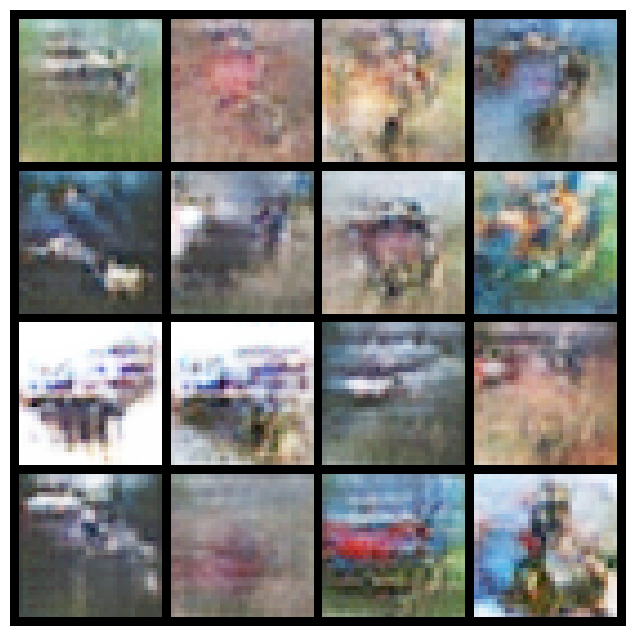

In [85]:
# instantiate Generator
generator = Generator().to(device)

# loading saved model from the 3-th fold
checkpoint_path = './models/best_GAN_generator_model_fold_5.pth'
generator.load_state_dict(torch.load(checkpoint_path, map_location=device))
generator.eval()

# Generate random noise
num_samples = 16 
fixed_noise = torch.randn(num_samples, latent_dim, device=device)

# generate images
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# display
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(fake_images, nrow=4, padding=2, normalize=True), (1, 2, 0)))
plt.show()

<img src="./images/GAN.png" alt="示例图片" width="500">

## <a id='toc3_3'></a>[Method 2.3: Stable Diffusion](#toc0_)

<img src="./images/SD.png" alt="示例图片" width="700">

The core concept behind these models is deceptively simple:
- Take a starting image
- Add some noise, iteratively degrading the image until almost nothing but noise remains.
- Train a model to 'undo' these noise steps.
- To generate, start from pure noise and repeatedly apply the model to 'denoise' our way back to a plausible image.

The model generally has access to some representation of 't' - that is, how many noise steps have been applied to the image. And to make its job easier, we typically get the model to output a prediction for the *noise* that we could subtract from the noisy image to get a less noisy one, rather than spitting out the denoised image.

### Define some utility functions and handle the datasets.

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 83375.65 examples/s]


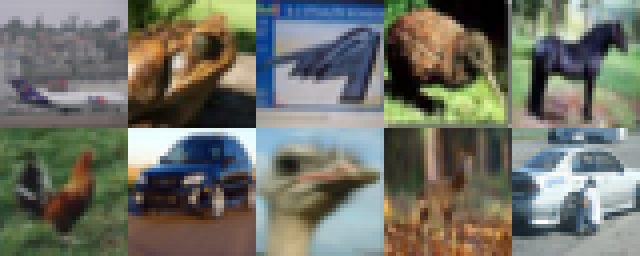

In [86]:
def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

# Download and load the dataset
cifar10 = load_dataset('cifar10')

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

### Add Noise

First, we want to define the spet that adds a little bit of noise - $q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$:

<img src="./images/addnoise.png" alt="示例图片" width="700">

We set up a 'variance schedule' β, where beta[t] ($\beta_t$)specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. The formula you'll see for this single noise step is:

$$
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
$$

We mix $\mathbf{x}_{t-1}$ with some gaussian noise, with how much noise decided by $\beta_t$. Let's see this in code and try applying it a bunch of times to an image:

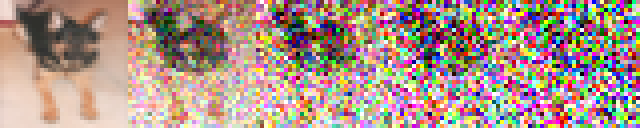

In [87]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):

    Beta_t =  beta[t]
    mean = torch.sqrt(1-Beta_t)*xtm1
    q_xt_xtminus1 = mean + torch.sqrt(Beta_t) * torch.distributions.Normal(0, 1).sample(mean.shape)

    return q_xt_xtminus1


# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))

  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample from t=37.

Luckily, some smart people did some [fancy maths](https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$
\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i
$

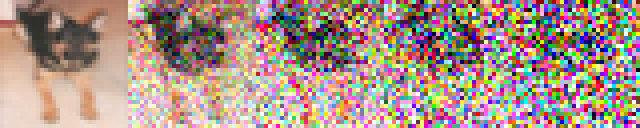

In [88]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):

    alpha_bar_t = alpha_bar[t]
    mean = torch.sqrt(alpha_bar_t)*x0
    q_xt_x0 = mean + torch.sqrt(1-alpha_bar_t) * torch.distributions.Normal(0, 1).sample(mean.shape)

    return q_xt_x0


# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

### UNet

<img src="./images/UNet.png" alt="示例图片" width="700">

To address the challenge of selecting an appropriate model for the 'denoising' step, we can consider various neural network architectures. Basic convolutional neural networks (CNNs) that accept an image as input and produce a classification output have been explored, as well as autoencoders, which map an image to a latent representation and then back to an output image. However, a common limitation of standard 'bottleneck' architectures like autoencoders is their inherent tendency to lose precise details, particularly those related to exact pixel coordinates. To overcome this limitation, the [UNet](https://arxiv.org/pdf/1505.04597) architecture was developed. Originally designed for segmentation tasks, the Unet architecture facilitates information flow from high-resolution, early layers to deeper layers. These 'shortcut' connections allow the network to retain detailed features from the original image while simultaneously learning higher-level semantic information in the deeper layers.

Unet-based networks have demonstrated considerable success in a variety of image-to-image translation tasks, such as colorization (DeOldify), segmentation, and others. In recent implementations, Unet models frequently integrate attention mechanisms (as the popular approach suggests) and are often built around pretrained 'backbone' networks like ResNet-50 to leverage transfer learning capabilities.

The following implementation (sourced directly from here) represents a modern Unet with an additional enhancement: a TimeEmbedding module. This module encodes the time step (t), allowing the model to utilize it as conditioning information by introducing it at an intermediate stage in the network.

In [89]:
# A fancy activation function
class Swish(nn.Module):
    """
    ### Swish actiavation function
    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

In [90]:
# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))
    
model = UNet()
print(model)

UNet(
  (image_proj): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(

### Preparing for training

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network. You don't **have** to do it this way, but the papers do, and we can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.

This training loop should look familiar from all the past lessons!

In [91]:
# Modified to return the noise itself as well
def q_xt_x0(x0, t):

    eps=torch.randn(x0.shape).to(device)
    alpha_bar_t = alpha_bar[t-1]
    xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1-alpha_bar_t) * eps

    return xt , eps

##loss calculation
def calc_loss(unet: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:

    # sample the time
    t=torch.randint(1,n_steps,(len(x),1,1,1)).to(device)
    x_t,eps = q_xt_x0(x,t)
    t=t.reshape(len(x),)
    eps_t = unet(x_t,t)
    loss = F.mse_loss(eps_t, eps)
    return loss

In [92]:
# Set up some parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Training params
batch_size = 128 # Lower this if hitting memory issues
lr = 1e-4 # Explore this - might want it lower when training on the full dataset
#2e-4
losses = [] # Store losses for later plotting

In [93]:
# Create the model
unet = UNet(n_channels=32).to(device)
optim = torch.optim.AdamW(unet.parameters(), lr=lr)

In [96]:
for data in trainloader:
  a=2*data[0]-1
  break
print(torch.min(a))

tensor(-1.)


### Train Model

**Due to the significant time and computational resources required for training, I have commented out the training process here.**

In [97]:
# checkpoint_dir = 'model_StableDiffusion_checkpoints'
# os.makedirs('model_StableDiffusion_checkpoints', exist_ok=True)
# dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=ToTensor())
# dloader=torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# t0 = time.time()
# losses = []

# for i_epoch in range(20):
#     total_loss = 0
#     for data in trainloader:
#         optim.zero_grad()

#         # train step
#         loss = calc_loss(unet, (2 * data[0] - 1).to(device))
#         loss.backward()
#         optim.step()

#         # Update statistics
#         total_loss += loss.item()

#     print(f"{i_epoch} ({time.time() - t0:.2f}s): Loss = {total_loss / len(dloader):.4f}")
#     losses.append(total_loss / len(dloader))

#     # save checkpoints
#     if (i_epoch + 1) % 5 == 0:
#         checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch_{i_epoch}.pth")
#         torch.save({
#             'epoch': i_epoch,
#             'model_state_dict': unet.state_dict(),
#             'optimizer_state_dict': optim.state_dict(),
#             'loss': total_loss / len(dloader),
#         }, checkpoint_path)
    
#         print(f"Model saved to {checkpoint_path}")

# plt.plot(losses)


Files already downloaded and verified
0 (263.84s): Loss = 1.1261
1 (525.91s): Loss = 0.7967
2 (790.11s): Loss = 0.7658
3 (1052.56s): Loss = 0.7439
4 (1316.25s): Loss = 0.7295
Model saved to model_StableDiffusion_checkpoints/unet_epoch_4.pth
5 (1579.22s): Loss = 0.7115
6 (1839.84s): Loss = 0.7088
7 (2101.23s): Loss = 0.6992
8 (2363.71s): Loss = 0.6942
9 (2625.75s): Loss = 0.6885
Model saved to model_StableDiffusion_checkpoints/unet_epoch_9.pth
10 (2888.48s): Loss = 0.6954
11 (3150.36s): Loss = 0.6772
12 (3412.68s): Loss = 0.6800
13 (3675.88s): Loss = 0.6725
14 (3938.55s): Loss = 0.6876
Model saved to model_StableDiffusion_checkpoints/unet_epoch_14.pth
15 (4202.45s): Loss = 0.6705
16 (4465.88s): Loss = 0.6693
17 (4727.14s): Loss = 0.6702
18 (4990.12s): Loss = 0.6586
19 (5252.41s): Loss = 0.6638
Model saved to model_StableDiffusion_checkpoints/unet_epoch_19.pth



<img src="./images/SD_loss.png" alt="示例图片" width="500">

### The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image:

In [98]:
def p_xt(xt, noise, t):

    alpha_t = alpha[t-1]
    alpha_bar_t = alpha_bar[t-1]
    if t>1:
      z = torch.randn(xt.shape).to(device)
    else:
      z = torch.zeros(xt.shape).to(device)
    sigma_t = torch.sqrt(beta[t-1])
    x_tm1 = (  xt - ( noise*(1-alpha_t)/torch.sqrt(1-alpha_bar_t) )  ) / (torch.sqrt(alpha_t))  + sigma_t*z

    return x_tm1

### Display generated images

In [100]:
unet = UNet(n_channels=32).to(device)
optim = torch.optim.Adam(unet.parameters(), lr=0.001)

# load saved model
checkpoint_dir = './models'
checkpoint_path = os.path.join(checkpoint_dir, 'unet_epoch_19.pth') 

if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    unet.load_state_dict(checkpoint['model_state_dict'])  # load weights
    optim.load_state_dict(checkpoint['optimizer_state_dict'])  # load optim
    start_epoch = checkpoint['epoch'] + 1  # start epoch for next training process
    loss = checkpoint['loss']  # load loss
    
unet.eval() 

x = torch.randn(10, 3, 32, 32).to(device) # Start with random noise
ims = []

for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
image.resize((32*4*5, 32*4*2), Image.NEAREST)

<img src="./images/SD_images.png" alt="示例图片" width="700">

## Finding in Image Generation Experiment

More complex generative models (`Stable Diffusion` > `GAN` > `VAE`) can produce higher-quality images. However, due to the low resolution of CIFAR-10 images, even when using the Stable Diffusion model, the quality of generated images remains unsatisfactory.